# Import pacakges

In [1]:
from WEB import *

In [2]:
import numpy as np

# Real data

### Initial value

In [3]:
# PROTEIN = "6z6u"
# EM_MAP = "11103"
PROTEIN = "7d1t"
EM_MAP = "30547"

BASE_NUM_POINTS = 8
MAX_POINTS = 8
MAX_ITER = 500
ALPHA = 0.2
GAMMA = 0.5
TOL = 1e-20

root_map=f'./dataset/emd_{EM_MAP}.map'
root_pdb=f'./dataset/{PROTEIN}.pdb'

### read data

In [4]:
web = WEB(start_radius=0, max_radius=1, gap=0.1)
data = web.read_data(
    root_map=root_map, 
    root_pdb=root_pdb,
    atoms=["CA"],
    base_num_points=BASE_NUM_POINTS, 
    max_points=MAX_POINTS, 
    )

100%|██████████| 5300/5300 [00:02<00:00, 2594.91it/s]


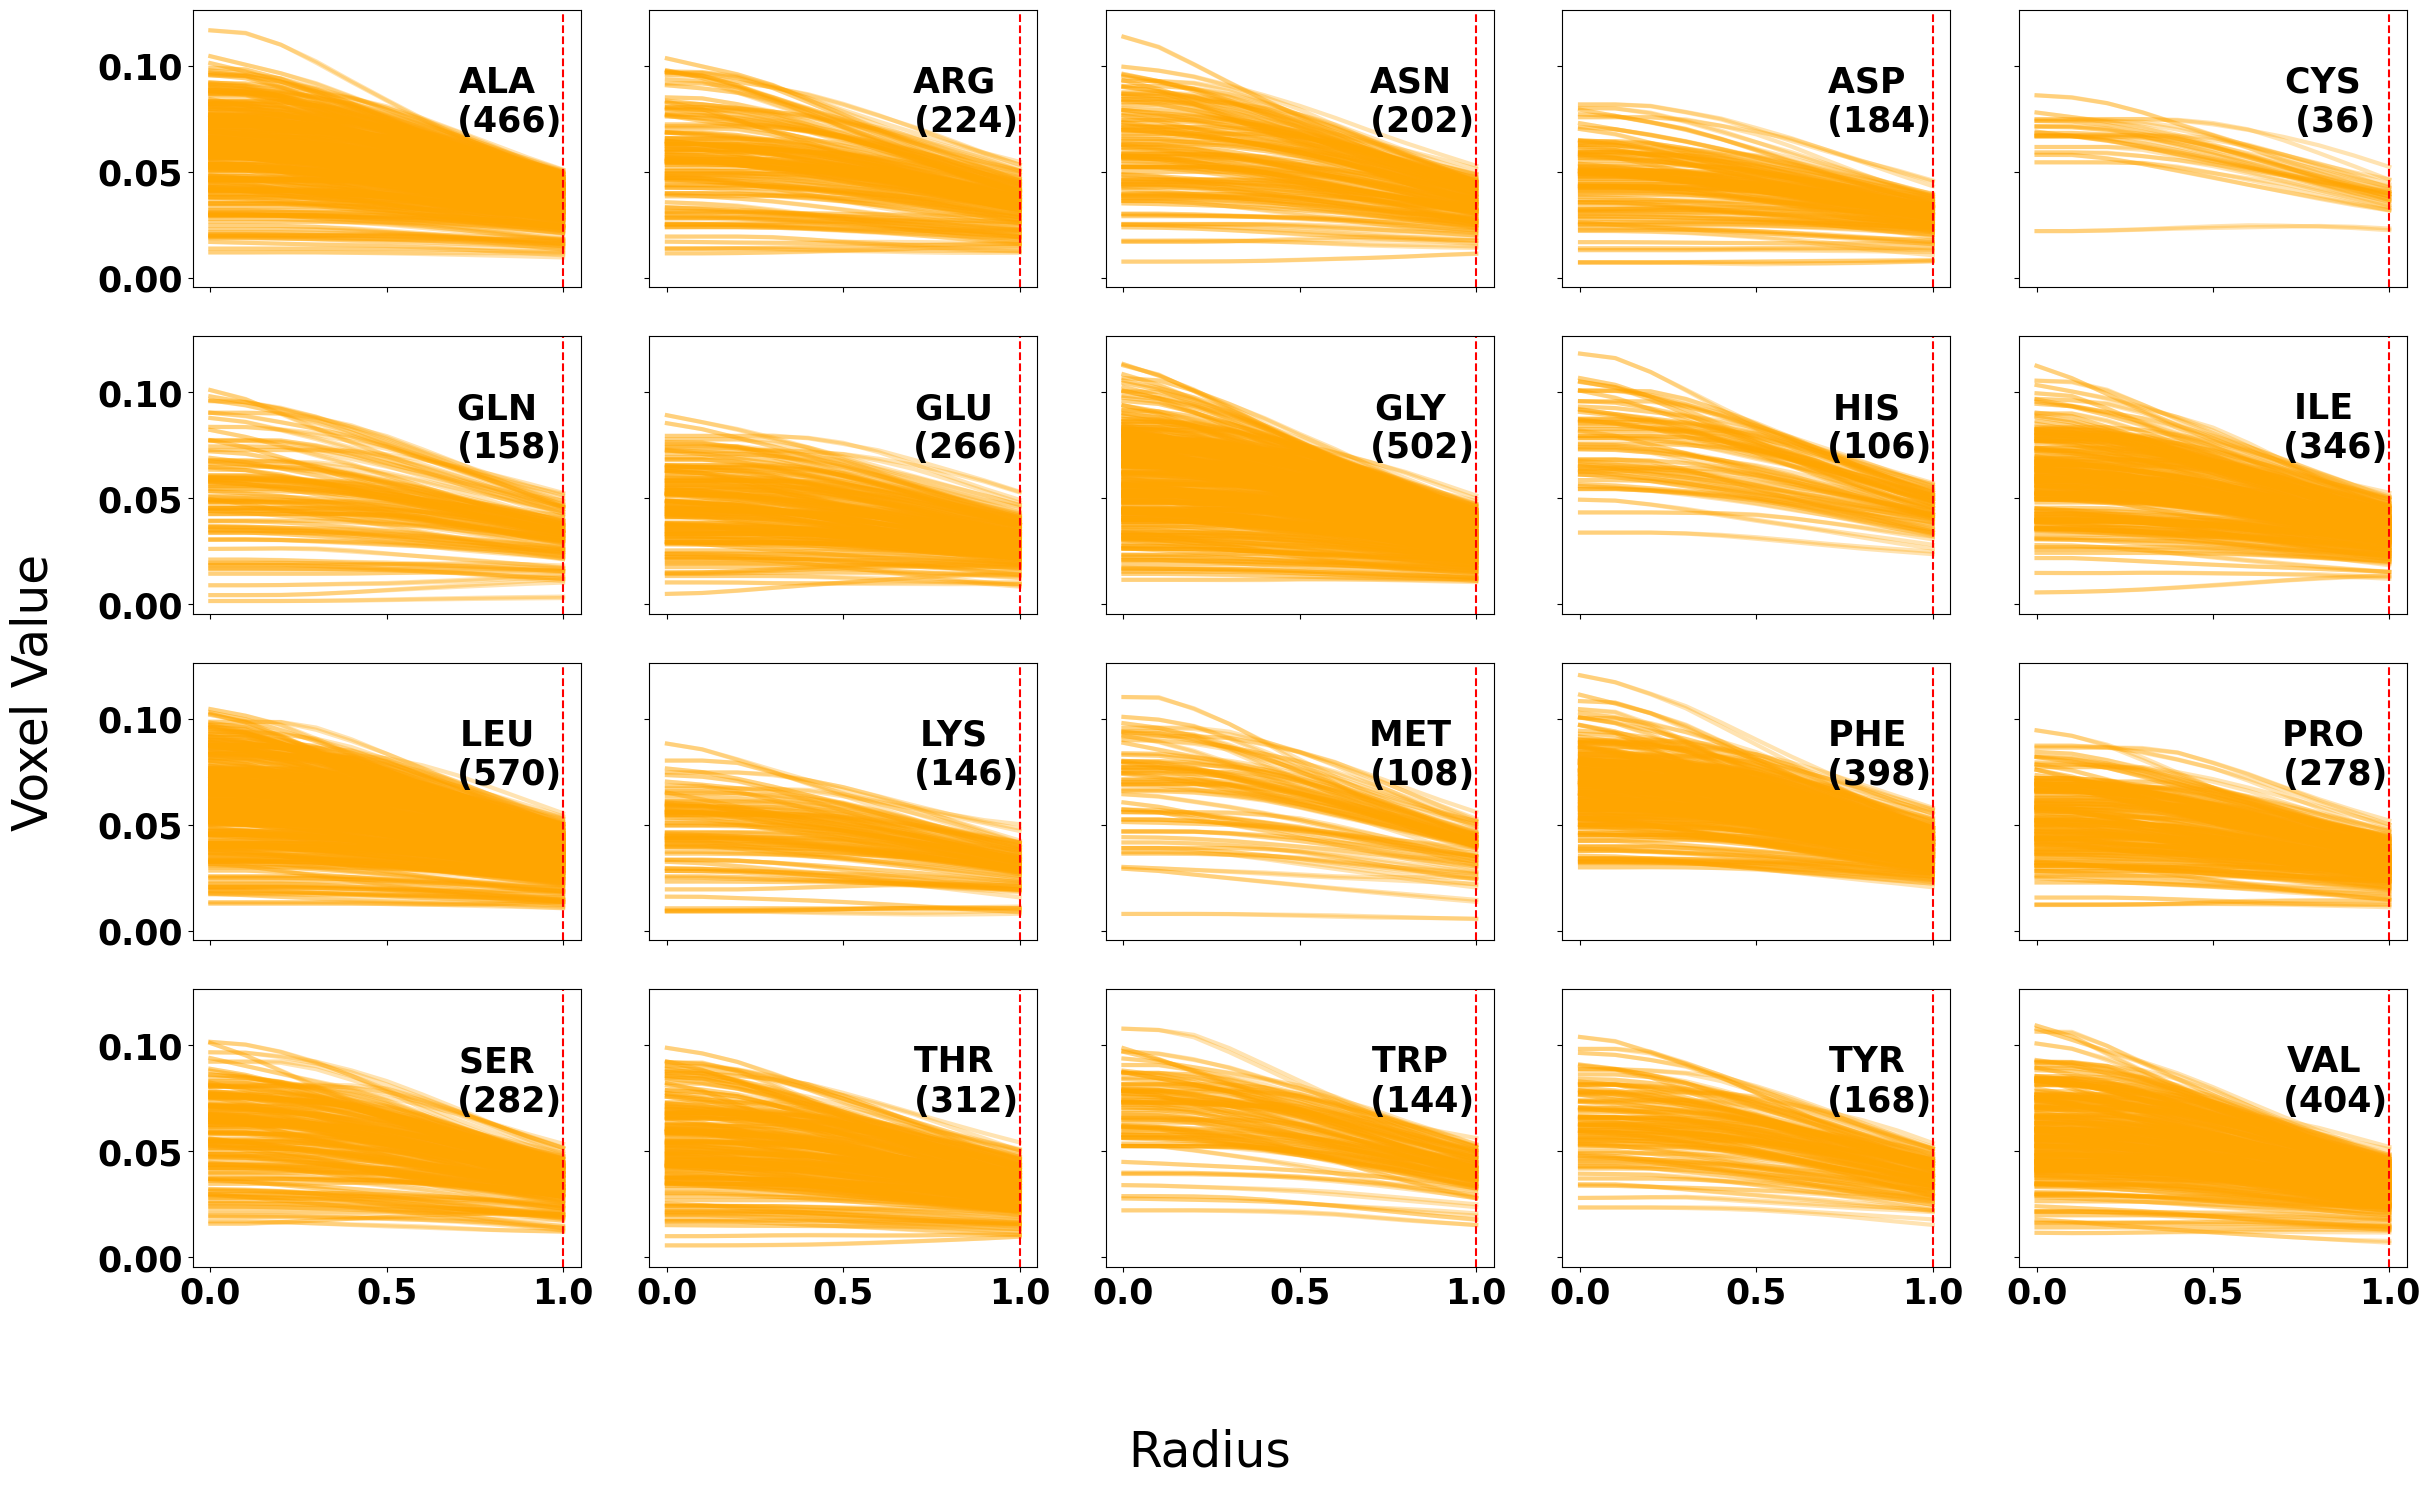

In [5]:
web.densities_plot(f"./figures/densities_plot_{PROTEIN}_{EM_MAP}")

### Fit our model

In [6]:
_ = web.parameters_initial()
betas_WEB = web.WEB_iter(max_iter=MAX_ITER, alpha=ALPHA, gamma=ALPHA, tol=TOL)

INFO:root:ALA MDPDE finished in iteration: 176
INFO:root:ALA WEB finished in iteration: 20
INFO:root:===================================
INFO:root:ARG MDPDE finished in iteration: 199
INFO:root:ARG WEB finished in iteration: 21
INFO:root:===================================
INFO:root:ASN MDPDE finished in iteration: 129
INFO:root:ASN WEB finished in iteration: 17
INFO:root:===================================
INFO:root:ASP MDPDE finished in iteration: 117
INFO:root:ASP WEB finished in iteration: 23
INFO:root:===================================
INFO:root:CYS MDPDE finished in iteration: 17
INFO:root:CYS WEB finished in iteration: 17
INFO:root:===================================
INFO:root:GLN MDPDE finished in iteration: 80
INFO:root:GLN WEB finished in iteration: 20
INFO:root:===================================
INFO:root:GLU MDPDE finished in iteration: 32
INFO:root:GLU WEB finished in iteration: 17
INFO:root:===================================
INFO:root:GLY MDPDE finished in iteration: 2

Check convergency

In [7]:
def func(theta, X_tilde, y_tilde, alpha):
    beta, sigma = theta[:2], theta[2]
    resedual = y_tilde - np.dot(X_tilde, beta)
    weight = np.exp(-alpha * resedual ** 2 / (2 * sigma))
    ans1 = np.sum(X_tilde * (resedual * weight).reshape(-1, 1), axis=0)
    ans2 = np.sum((1 - resedual ** 2 / sigma) * weight, axis=0) - alpha / (1 + alpha) ** (3 / 2)
    return np.append(ans1, ans2)

In [8]:
name = "GLY"
j = 11
X_tilde, y_tilde = web.Xs_tilde[name][j], web.data_log[name][j]
beta, sigma = web.betas_MDPDE[name][j], web.sigmas_MDPDE[name][j]
alpha = 0.2
func(np.append(beta, sigma), X_tilde, y_tilde, alpha)

array([-4.53781580e-04,  1.85164500e-04,  1.32405577e+01])

Solve A and tau

In [9]:
estimators_list = list(map(solve, web.mus_mle.values()))
estimators = {name: estimator for name, estimator in zip(web.mus_mle, estimators_list)}
sigmas_WEB = {name: value[0] for name, value in estimators.items()}
estimators

{'ALA': (0.916366822333933, 0.0674400501777167),
 'ARG': (1.00625413876499, 0.05422224858407111),
 'ASN': (0.8816771466499365, 0.06977903804973244),
 'ASP': (1.0046094234386, 0.04591786217659119),
 'CYS': (0.8249174438218138, 0.09123206456174882),
 'GLN': (1.0093483643272176, 0.05092874836570073),
 'GLU': (1.0117978843405353, 0.04408206806237429),
 'GLY': (0.71760321848611, 0.0953672219525532),
 'HIS': (0.8766655213410974, 0.09129740285807818),
 'ILE': (0.8898142886704492, 0.06908101149767637),
 'LEU': (0.887189042016846, 0.07168841227976826),
 'LYS': (1.0840909004902282, 0.04274365136980832),
 'MET': (0.8301087570410416, 0.08993357270864823),
 'PHE': (0.8640194823833994, 0.08288403118137187),
 'PRO': (0.9316714364308931, 0.05757377338699811),
 'SER': (0.9176534232300112, 0.06548060560336078),
 'THR': (0.9195540920573103, 0.05840296746778903),
 'TRP': (0.8977752339874454, 0.08128592530159216),
 'TYR': (0.9270942405084475, 0.07066217098791772),
 'VAL': (0.9079547646592541, 0.06503294426

Compare Q-scores 

In [10]:
x = np.unique(web.distances_to_center["ALA"][0])
x = np.repeat(x, BASE_NUM_POINTS)

In [11]:
all_data = None
for data in web.data.values():
    if all_data is None:
        all_data = data
    else:
        all_data = np.concatenate((all_data, data), axis=0)
avg_M = all_data.mean(axis=0)
sigma_M = all_data.std(axis=0)
# A = avg_M + 10 * sigma_M
# B = avg_M - sigma_M
A, B = 1, 1
sigma = 0.6
y = (A * np.exp(-1 / (2 * sigma**2) * x**2) + B).tolist()
gaussian_q_score = {name: np.array(y * len(beta)).reshape(-1, len(y)) for name, beta in web.betas_MDPDE.items()}

In [12]:
X_tilde = web.Xs_tilde["ALA"][0]
gaussian_WEB = {name: None for name in web.residue_order}
for name, beta in web.betas_WEB.items():
    gaussian_WEB[name] = np.exp(beta @ X_tilde.T)

In [13]:
q_scores = calculate_similarity(web.data, gaussian_q_score)
q_scores_WEB = calculate_similarity(web.data, gaussian_WEB)

In [14]:
font = {'weight' : 'bold', 'size': 10}
matplotlib.rc('font', **font)
for name, q_score, q_score_WEB in zip(q_scores.keys(), q_scores.values(), q_scores_WEB.values()):
    q_score = np.array(q_score)
    q_score_WEB = np.array(q_score_WEB)
    print(name, round(sum(q_score > q_score_WEB) / len(q_score), 4))
    # plt.scatter(q_score[q_score > q_score_WEB], q_score_WEB[q_score > q_score_WEB], c="red")
    # plt.scatter(q_score[q_score < q_score_WEB], q_score_WEB[q_score < q_score_WEB], c="green")
    # plt.plot(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), color="black")
    # plt.xlim(-1, 1)
    # plt.ylim(-1, 1)
    # plt.title(name)
    # plt.show()

ALA 0.3841
ARG 0.4241
ASN 0.4208
ASP 0.3533
CYS 0.3333
GLN 0.3544
GLU 0.3797
GLY 0.4024
HIS 0.4434
ILE 0.4595
LEU 0.4193
LYS 0.3767
MET 0.4259
PHE 0.3844
PRO 0.4424
SER 0.3865
THR 0.484
TRP 0.4167
TYR 0.3274
VAL 0.4975


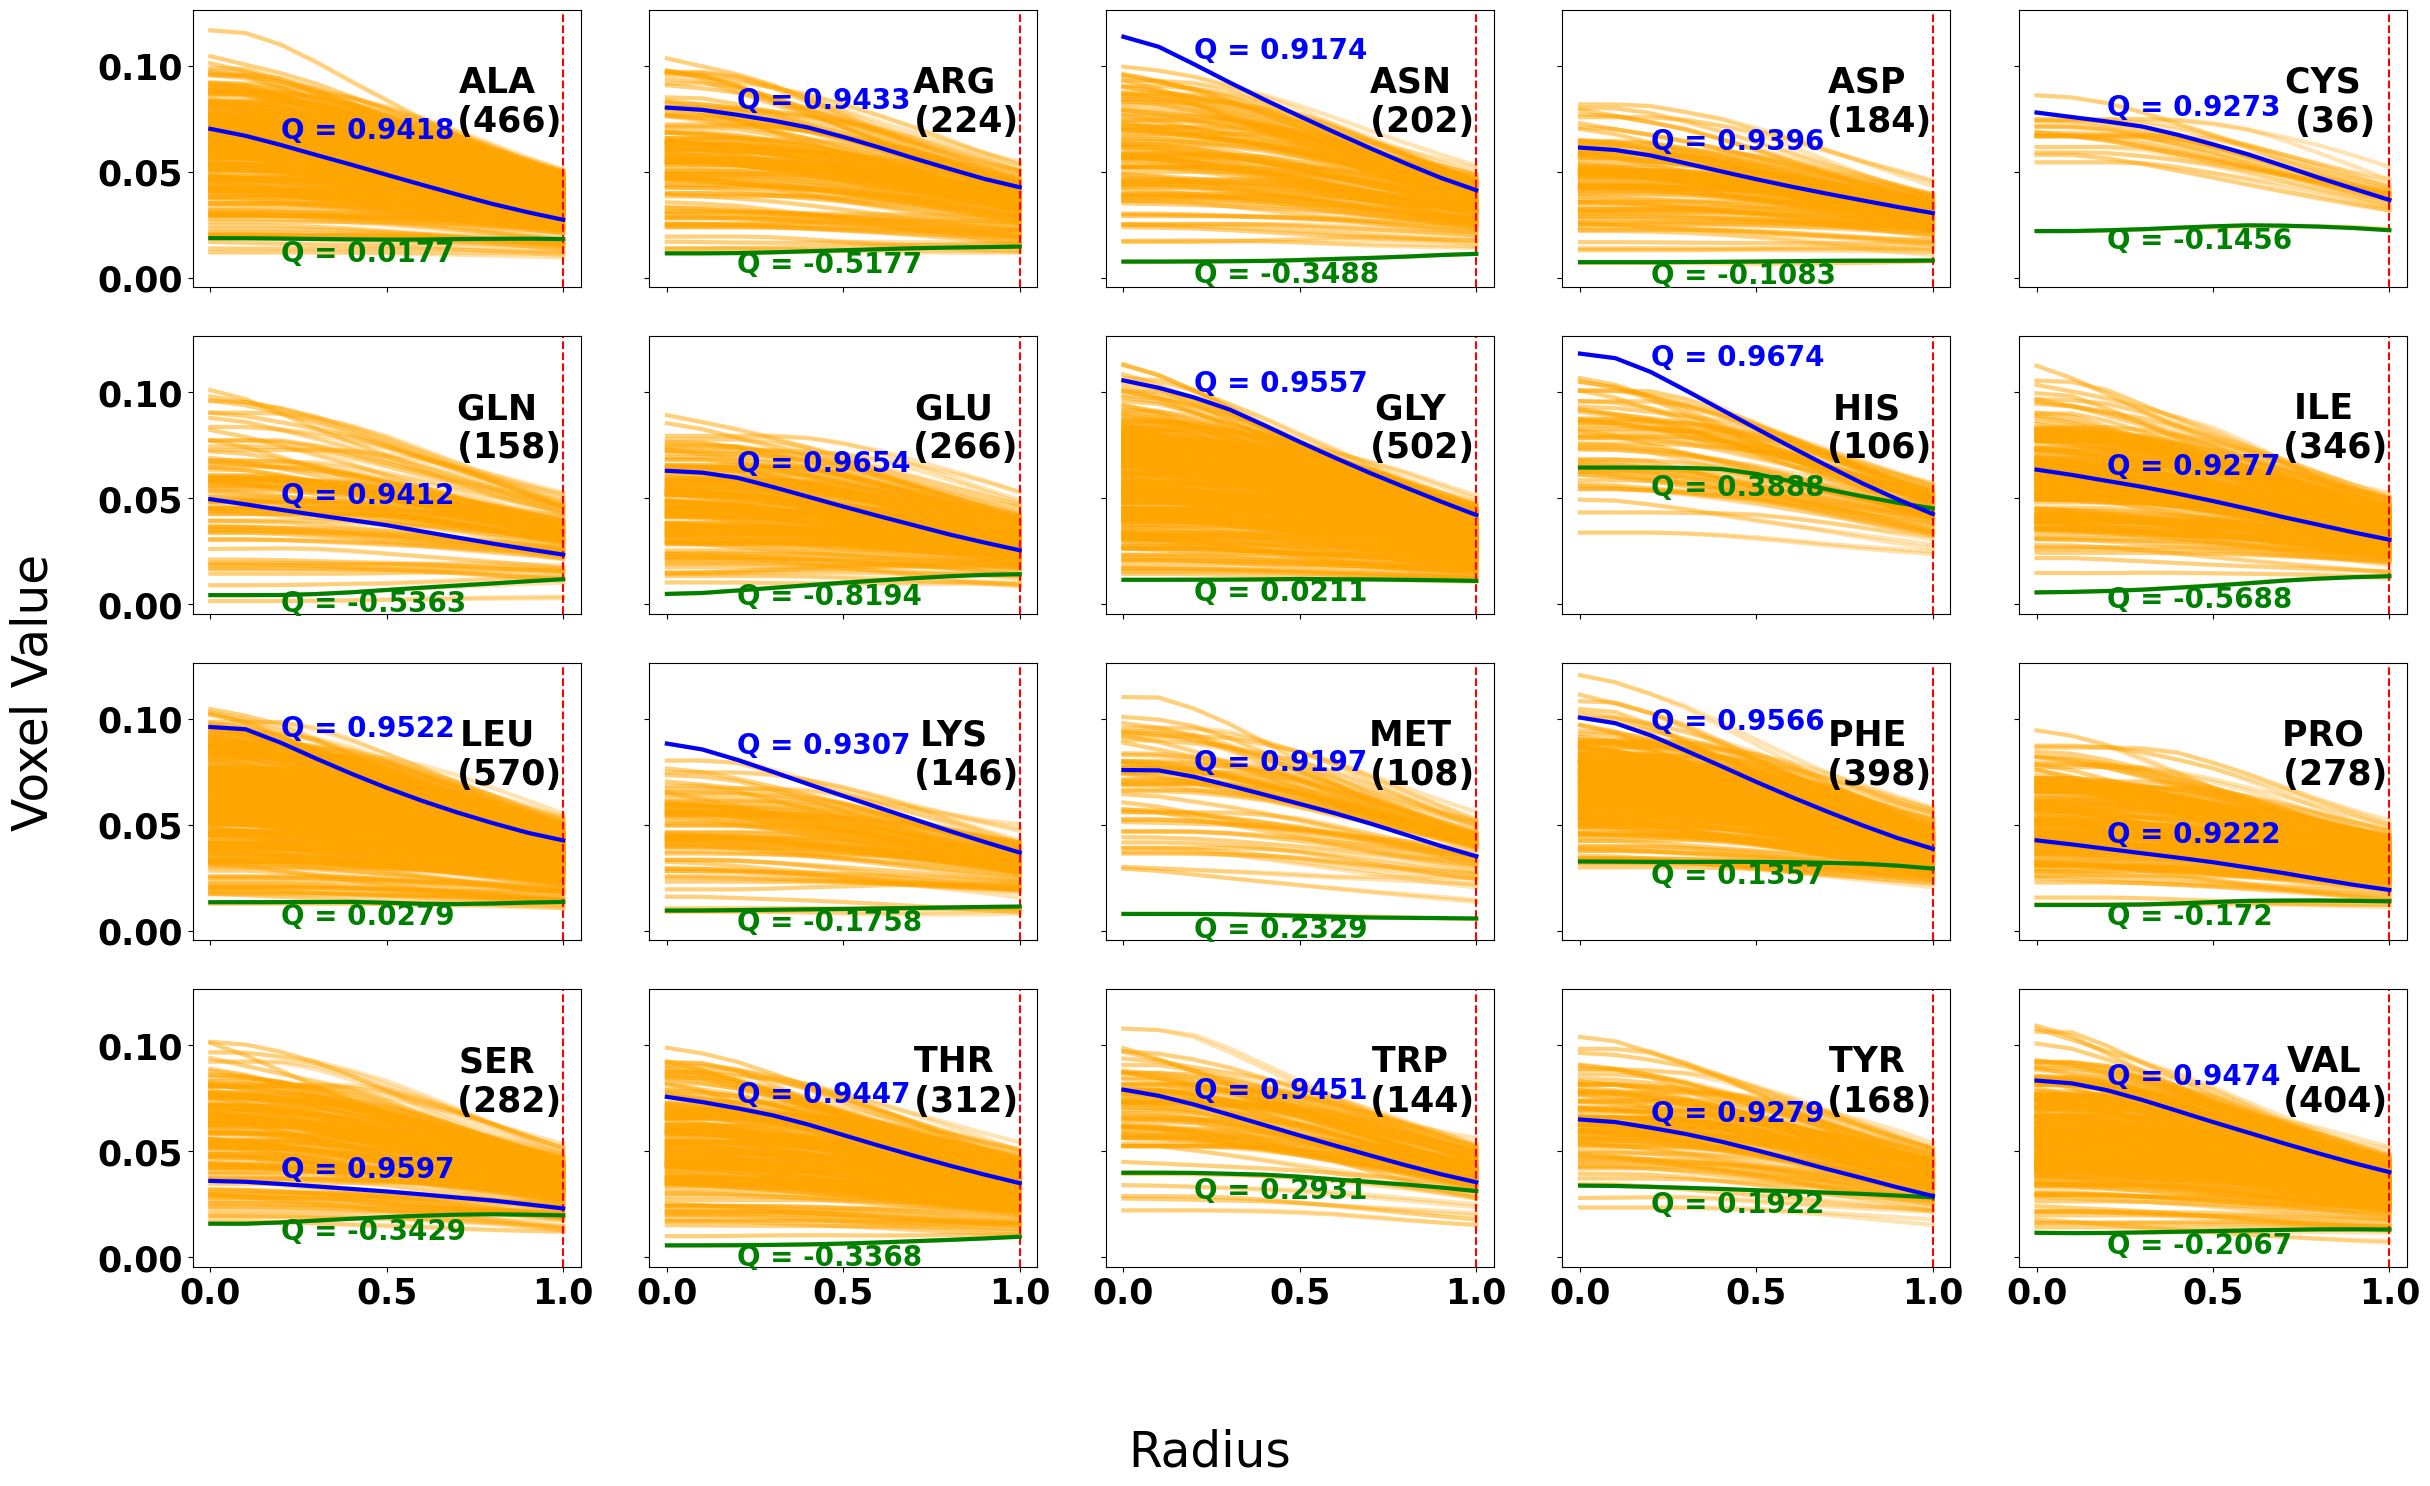

In [15]:
# q_scores = calculate_similarity(web.densities_data, web.densities_WEB)
web.densities_plot(f"./figures/densities_plot_{PROTEIN}_{EM_MAP}", q_scores=q_scores)

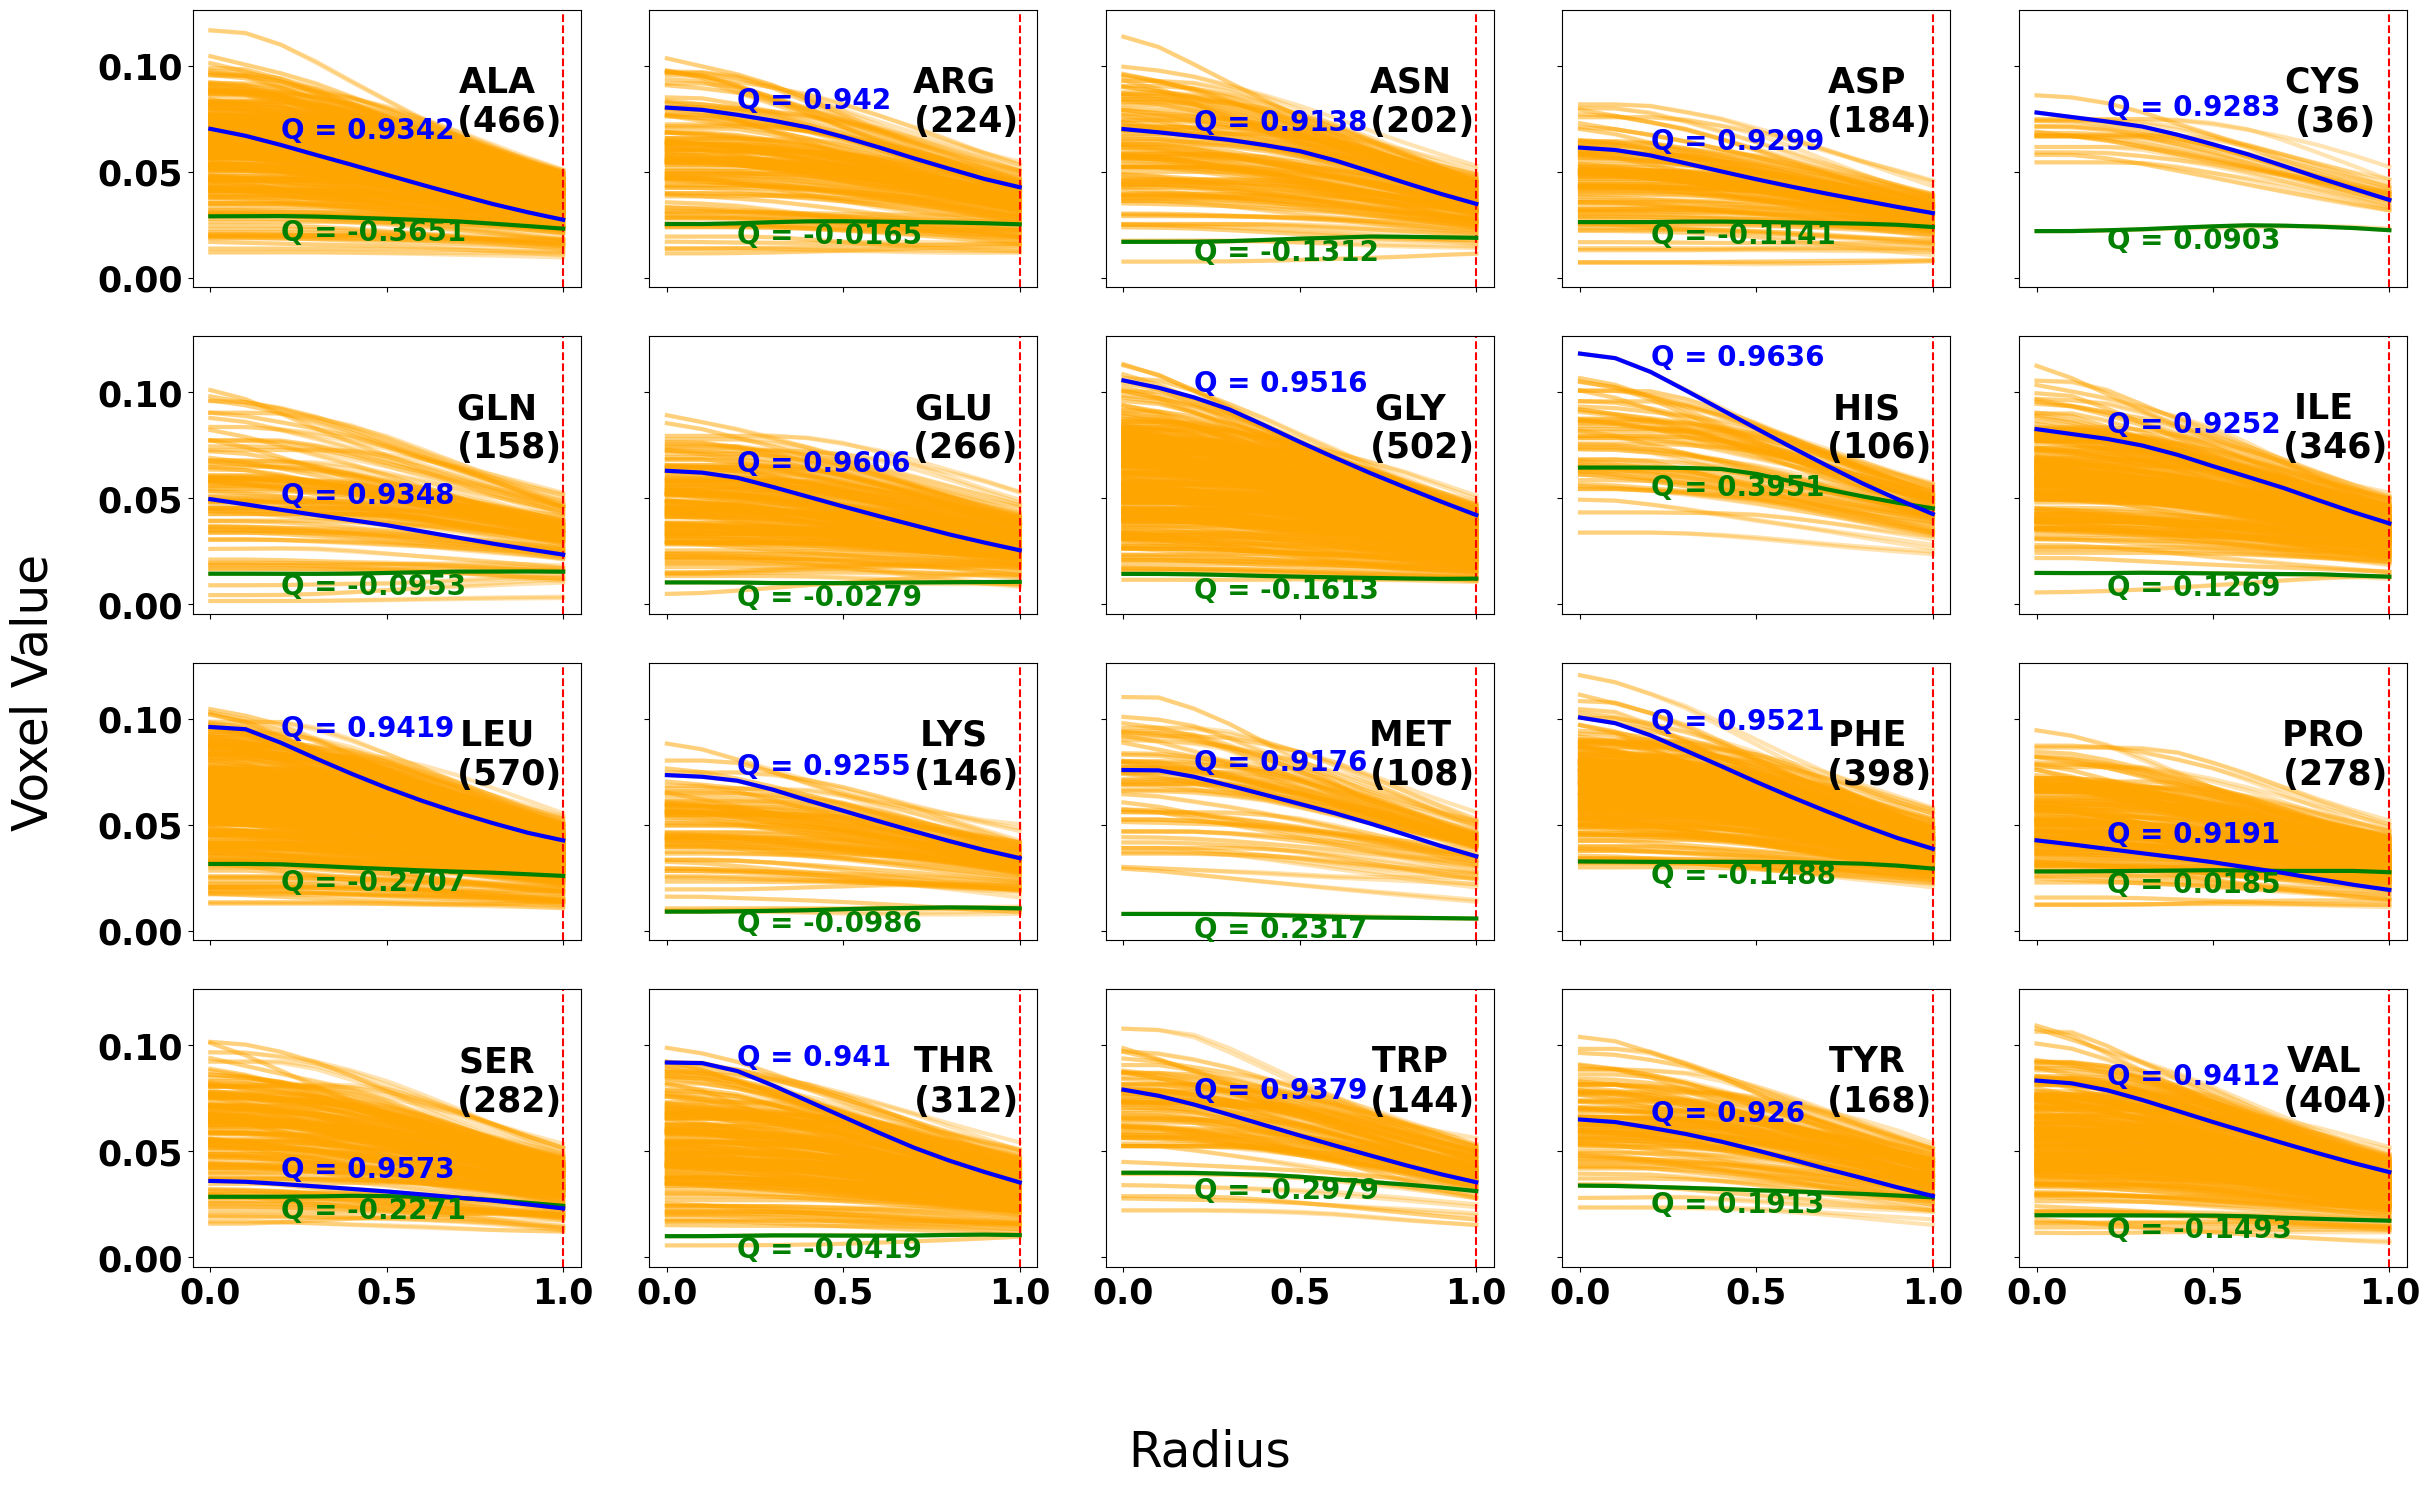

In [16]:
web.densities_plot(f"./figures/densities_plot_{PROTEIN}_{EM_MAP}", q_scores=q_scores_WEB)

### Plot results

<Figure size 640x480 with 0 Axes>

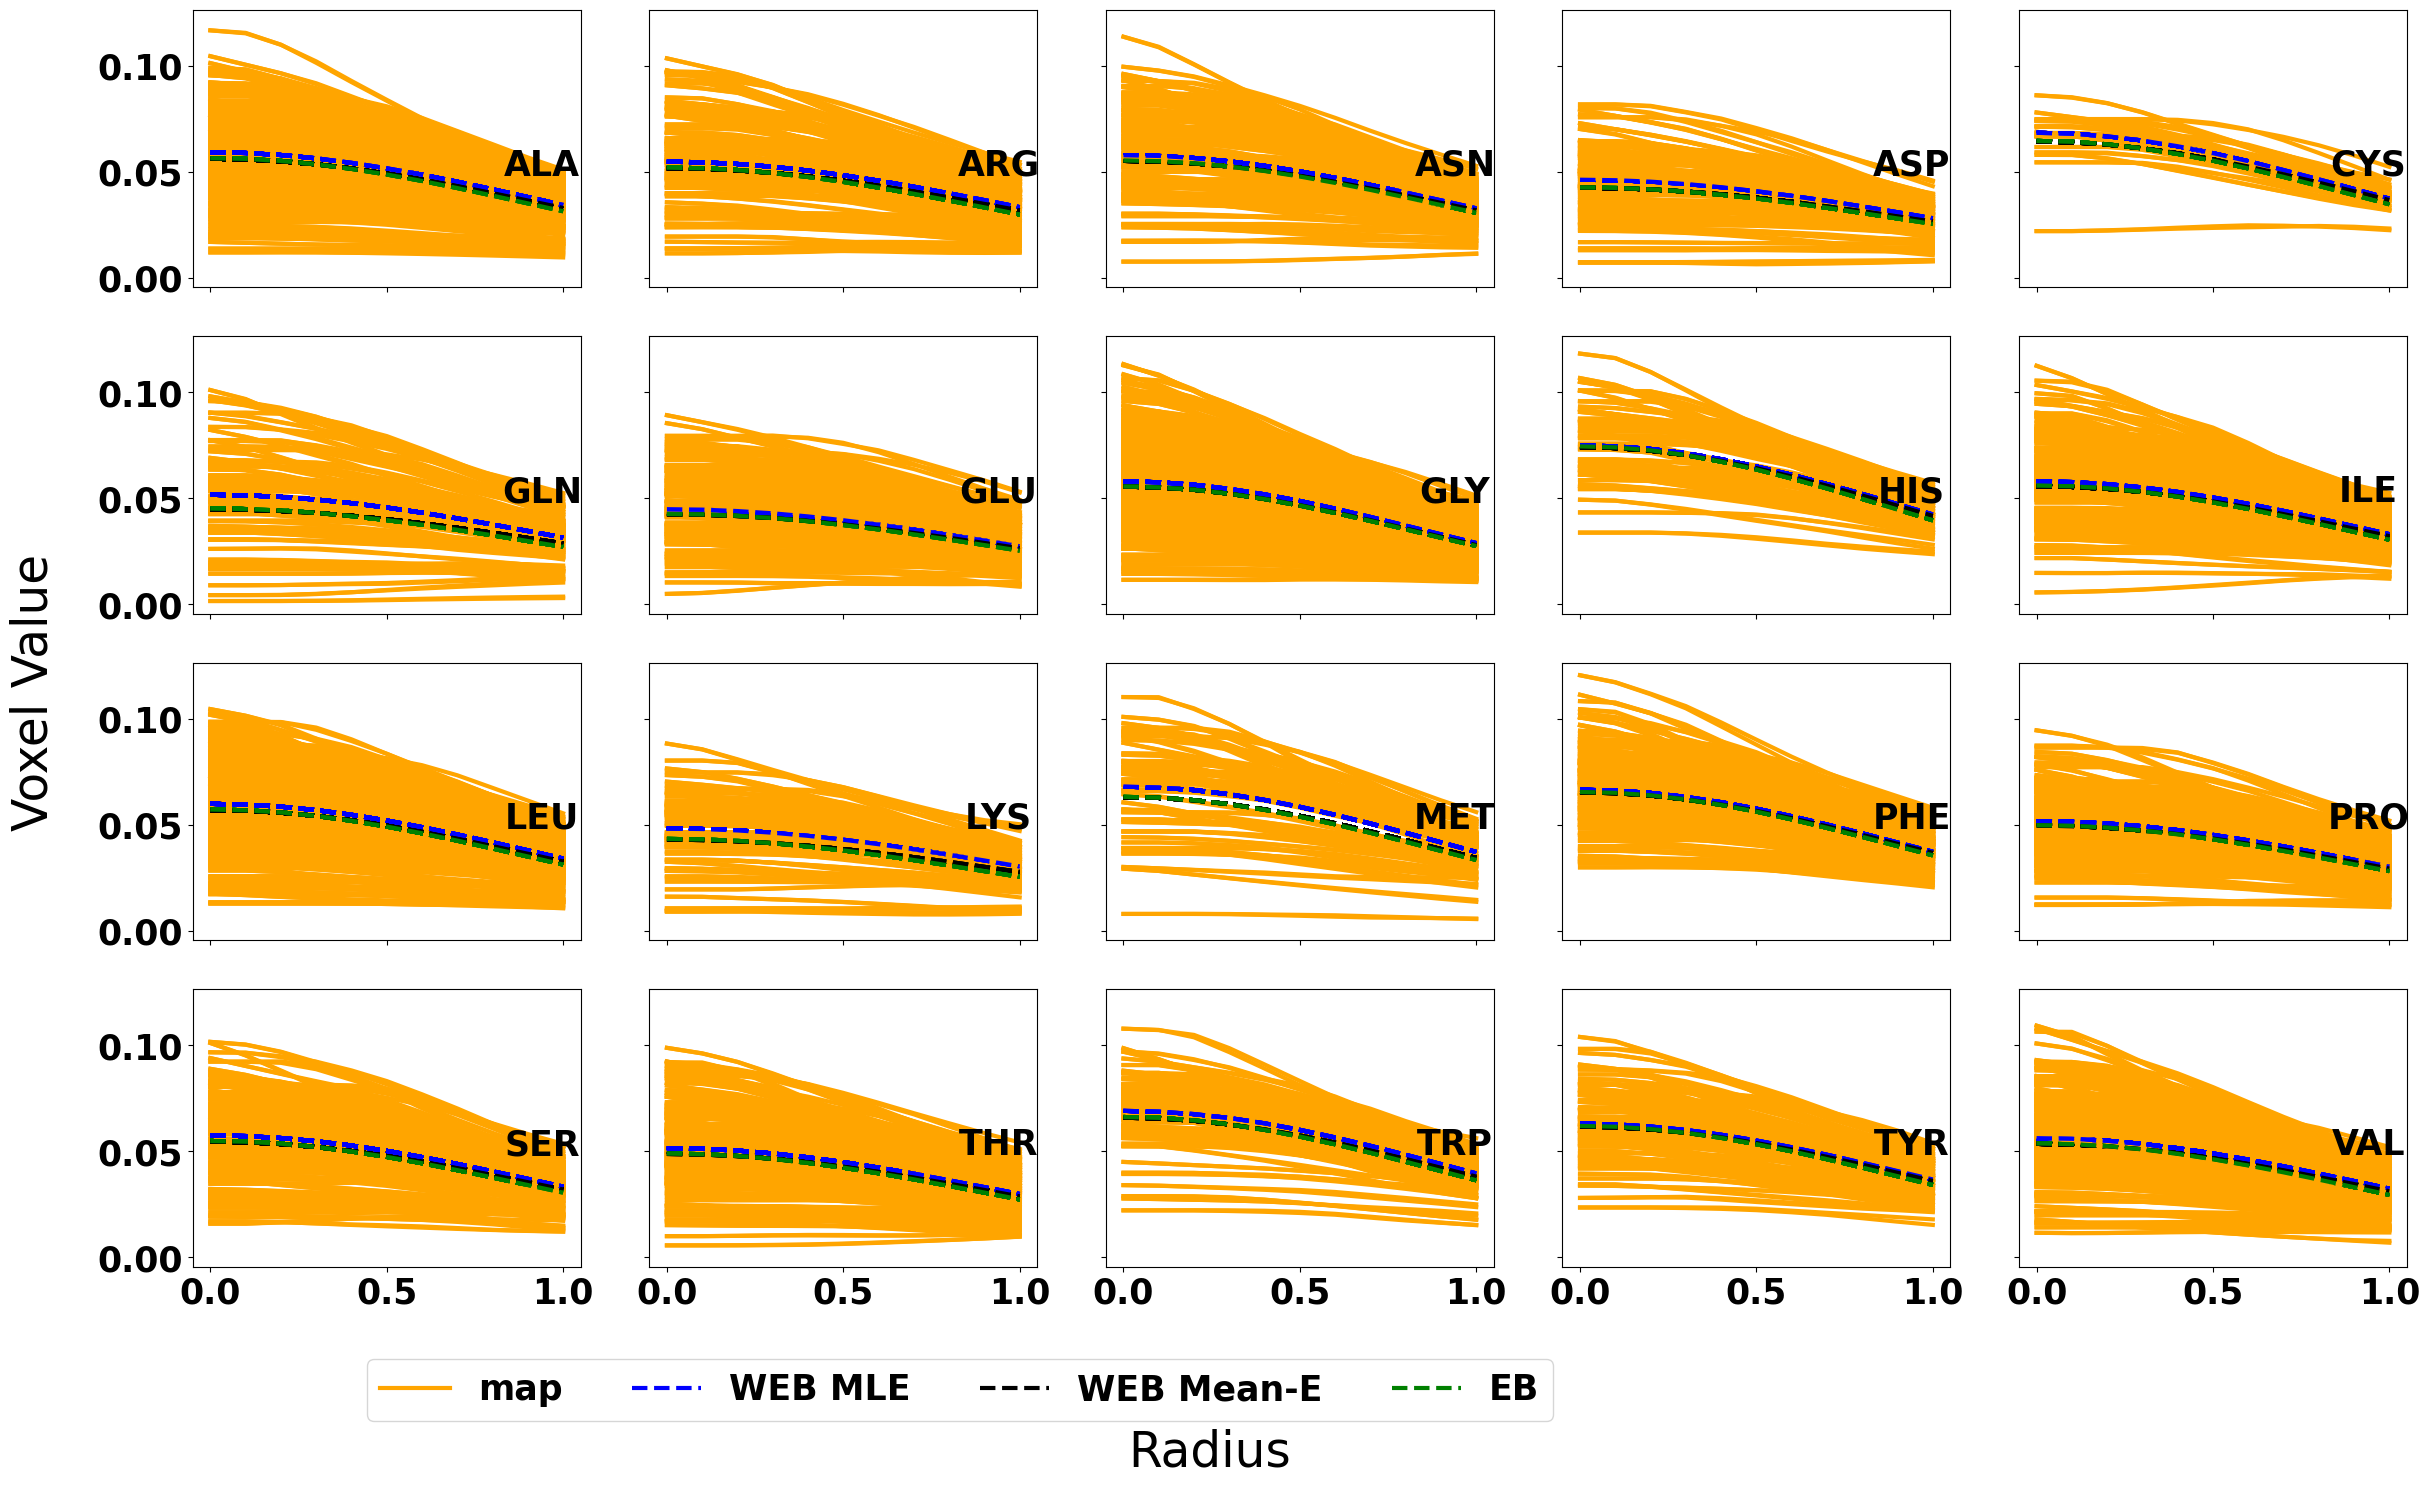

In [17]:
web.representative_densities_plot(
    # root = f"./figures/densities_compared_{PROTEIN}_{EM_MAP}_EB", 
    estimators = ["WEB MLE", "WEB Mean-E", "EB"]
    )

<Figure size 640x480 with 0 Axes>

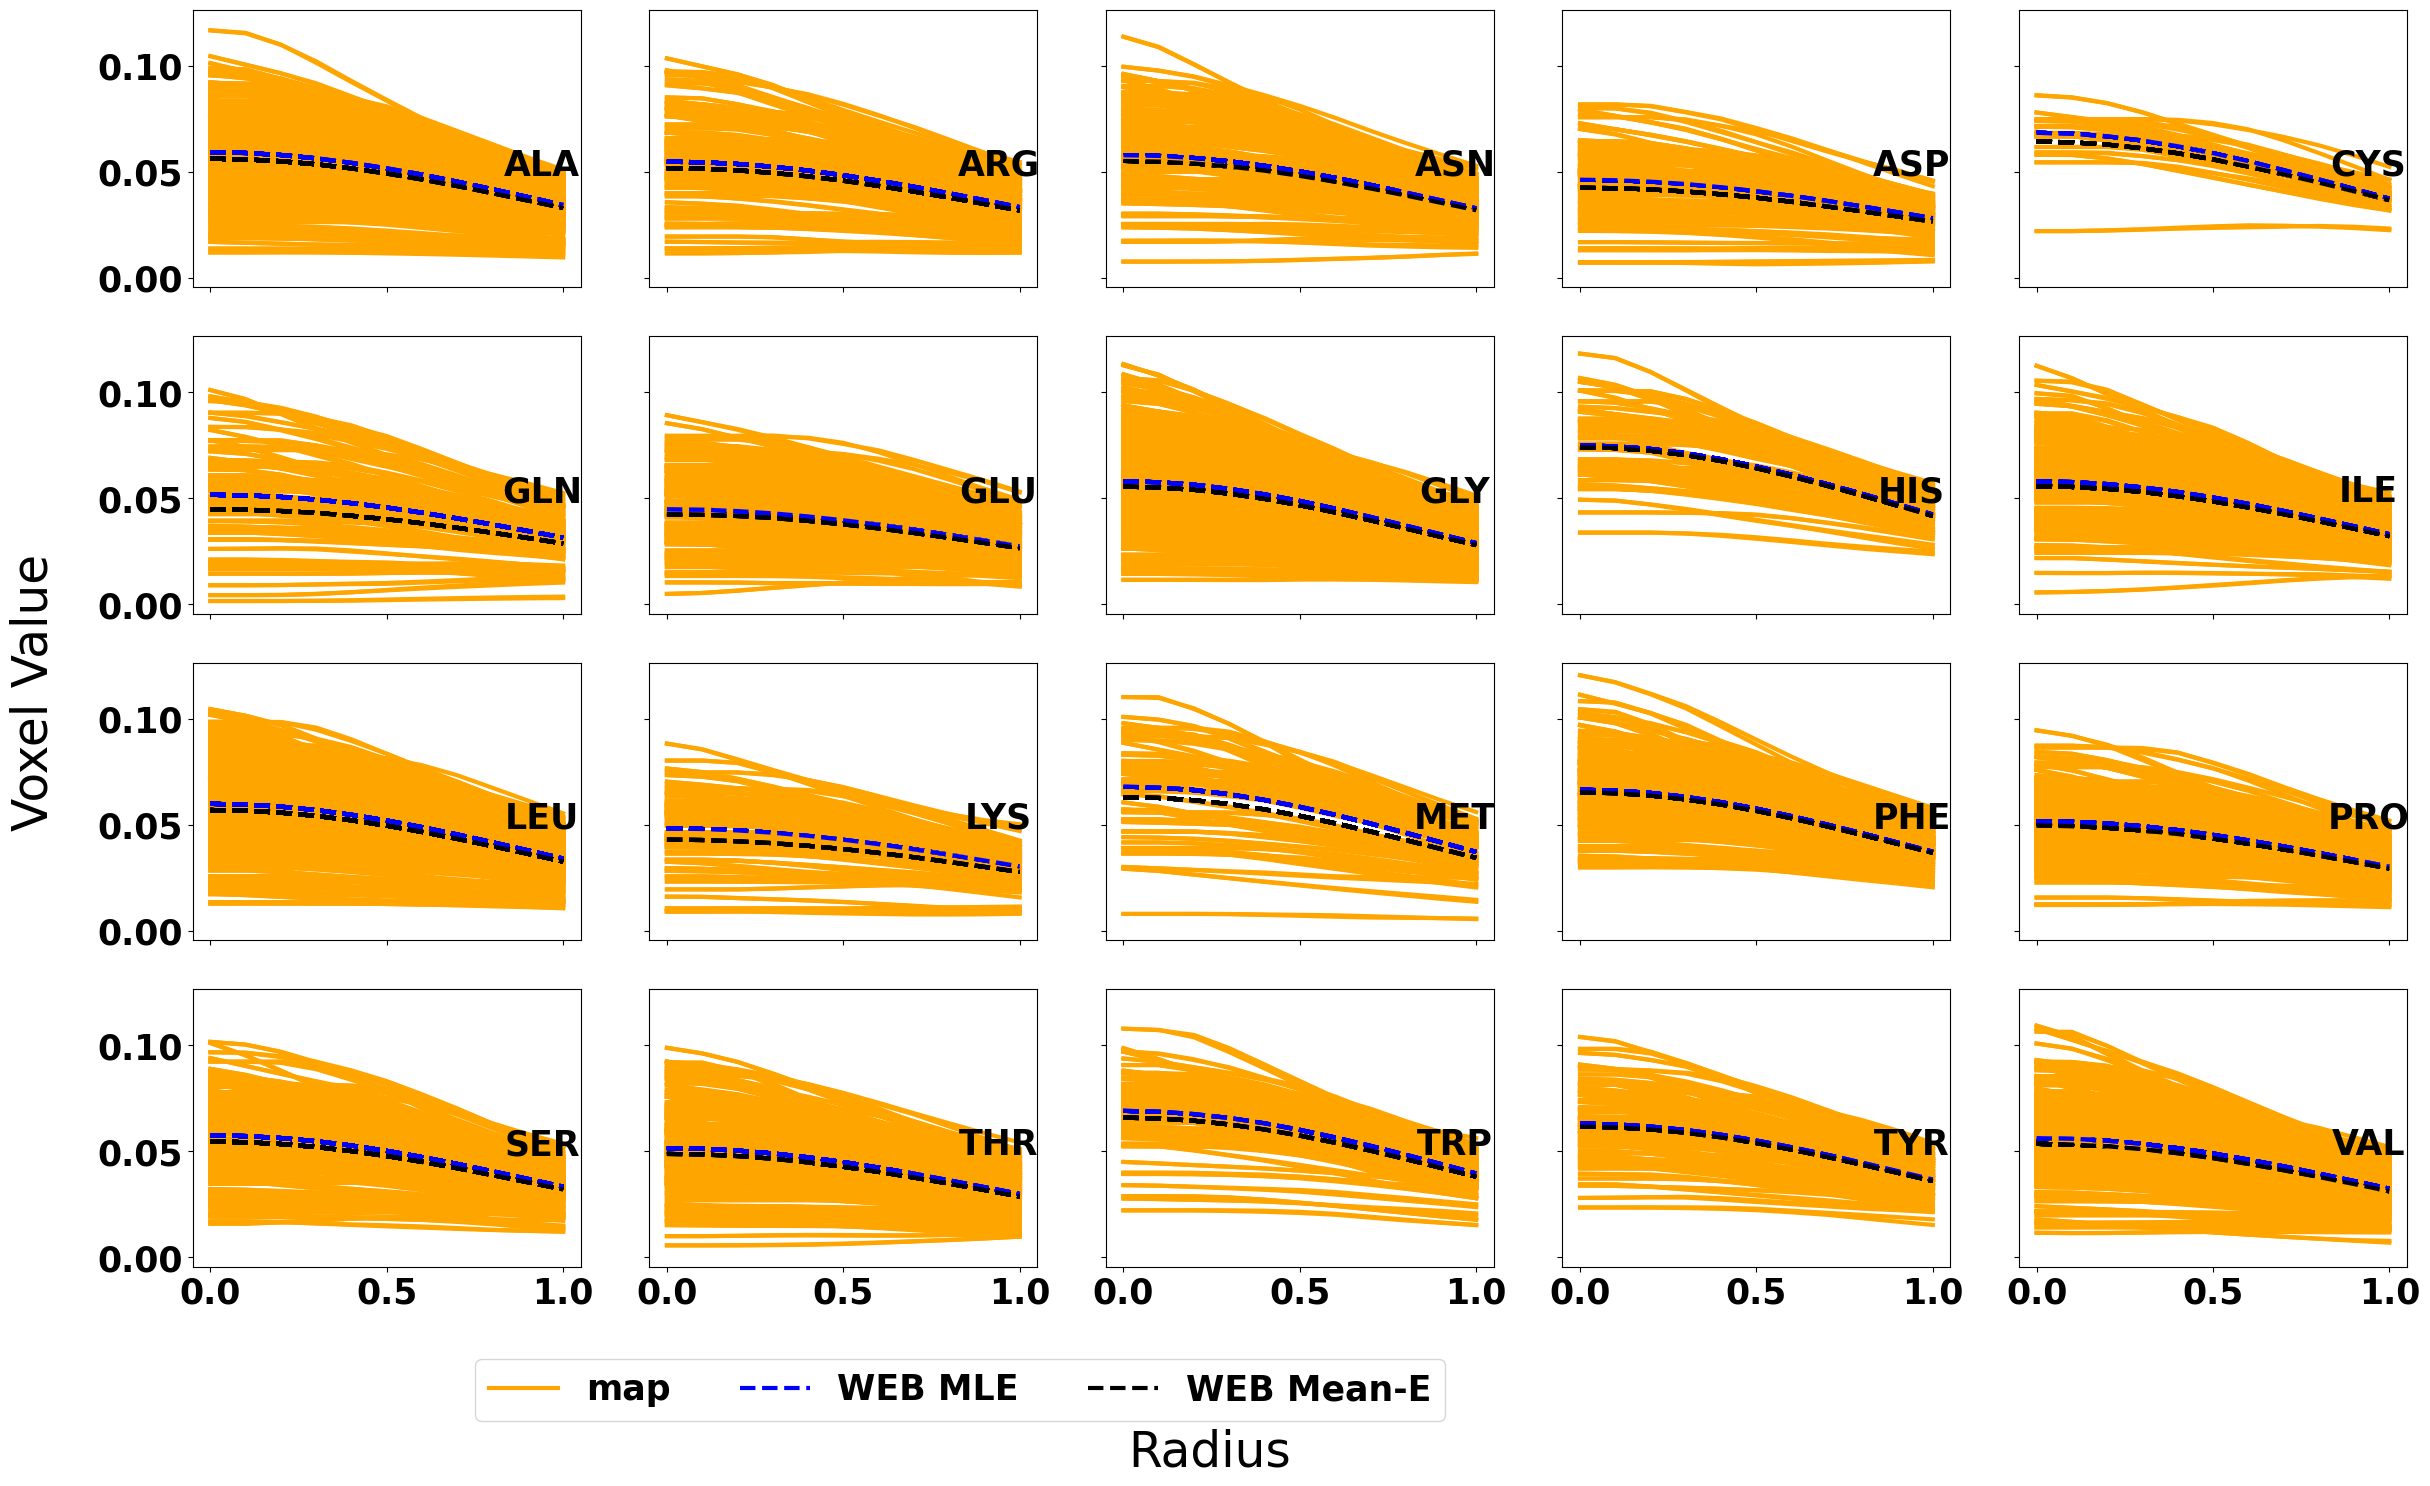

In [18]:
web.representative_densities_plot(
    # root = f"./figures/densities_compared_{PROTEIN}_{EM_MAP}", 
    estimators = ["WEB MLE", "WEB Mean-E"]
    )

### Find outliers

In [19]:
outliers, statistic_distances = web.find_outliers(prob=0.95)

In [20]:
for key, value in outliers.items():
    print(key, value)

ALA [0, 54, 58, 72, 84, 113, 125, 132, 138, 153, 168, 222, 272, 283, 294, 306, 327, 337, 361, 376, 390, 392, 395, 405, 407, 417, 421, 422, 430, 435, 451]
ARG [3, 27, 29, 32, 33, 41, 58, 66, 91, 104, 117, 159, 163, 172, 181, 188, 207, 213, 218]
ASN [12, 87, 88, 128, 129, 134, 158, 176, 181, 189, 199]
ASP [40, 54, 78, 102, 115, 116, 122, 134, 137, 153, 154, 155]
CYS [8, 12, 30]
GLN [6, 18, 66, 75, 78, 87, 95, 140, 142, 150, 154]
GLU [26, 57, 63, 69, 73, 81, 84, 102, 109, 208, 218, 223, 228, 248, 250, 262]
GLY [24, 47, 56, 65, 77, 84, 91, 101, 127, 142, 150, 156, 173, 186, 189, 190, 199, 205, 240, 256, 272, 309, 340, 345, 364, 378, 379, 388, 398, 462, 470, 481, 482, 501]
HIS [27, 35, 37, 55, 74, 96, 100, 103]
ILE [3, 14, 16, 34, 83, 99, 107, 122, 136, 156, 157, 170, 175, 255, 278]
LEU [5, 23, 47, 50, 69, 70, 75, 78, 95, 109, 122, 140, 172, 198, 206, 212, 250, 251, 271, 275, 304, 315, 346, 380, 437, 469, 506, 530, 540, 541, 543, 544, 545, 546, 548, 551, 555, 557, 561]
LYS [11, 33, 37, 64, 

In [21]:
for key, value in outliers.items():
    print(key, np.array(q_scores[key])[value])

ALA [0.40668357 0.48281839 0.60867376 0.2633544  0.59207186 0.05345104
 0.1958875  0.51668982 0.2527457  0.59961933 0.12765816 0.23428756
 0.22747894 0.91751344 0.35523018 0.42780988 0.75702308 0.78448566
 0.62686017 0.33139618 0.27915848 0.01765747 0.35300209 0.18067429
 0.29042999 0.2847271  0.34859253 0.11497239 0.28257032 0.29664305
 0.32361207]
ARG [ 0.61178538  0.02931692  0.41172002  0.82452446  0.67497912  0.10503132
 -0.1918767   0.291769    0.60637345  0.52786047 -0.00131232 -0.09899423
 -0.51766452  0.12470513 -0.28456283  0.48726872  0.83356016  0.2083348
 -0.1876323 ]
ASN [ 0.53876632  0.19749314 -0.14421726 -0.05643763  0.763395    0.31541063
 -0.32941397 -0.3488073   0.4443875   0.23646153  0.49532699]
ASP [ 0.76403322 -0.05709273  0.40676865  0.60206804 -0.02944404 -0.10600134
 -0.04780343 -0.04383086  0.58049042  0.08129307 -0.10833259 -0.0279227 ]
CYS [ 0.49688079 -0.12617824 -0.14557624]
GLN [ 0.54003057  0.2140783   0.43638554 -0.39165467 -0.29737426 -0.29743807
 -0

Take MET for example

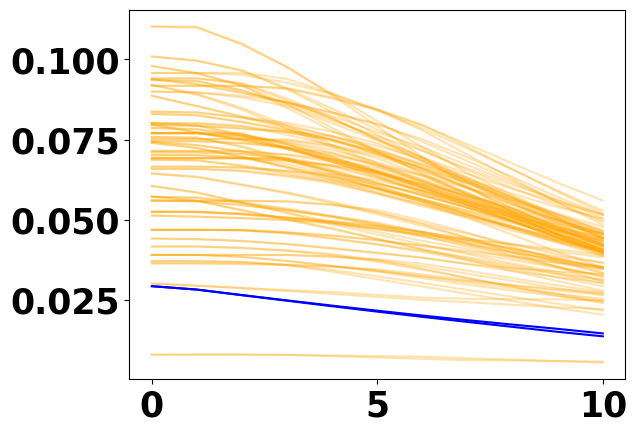

In [25]:
for i, density in enumerate(web.densities_data["MET"]):
    if i in [9, 90]:
        plt.plot(density, color="blue")
    else:
        plt.plot(density, color="orange", alpha=0.3)

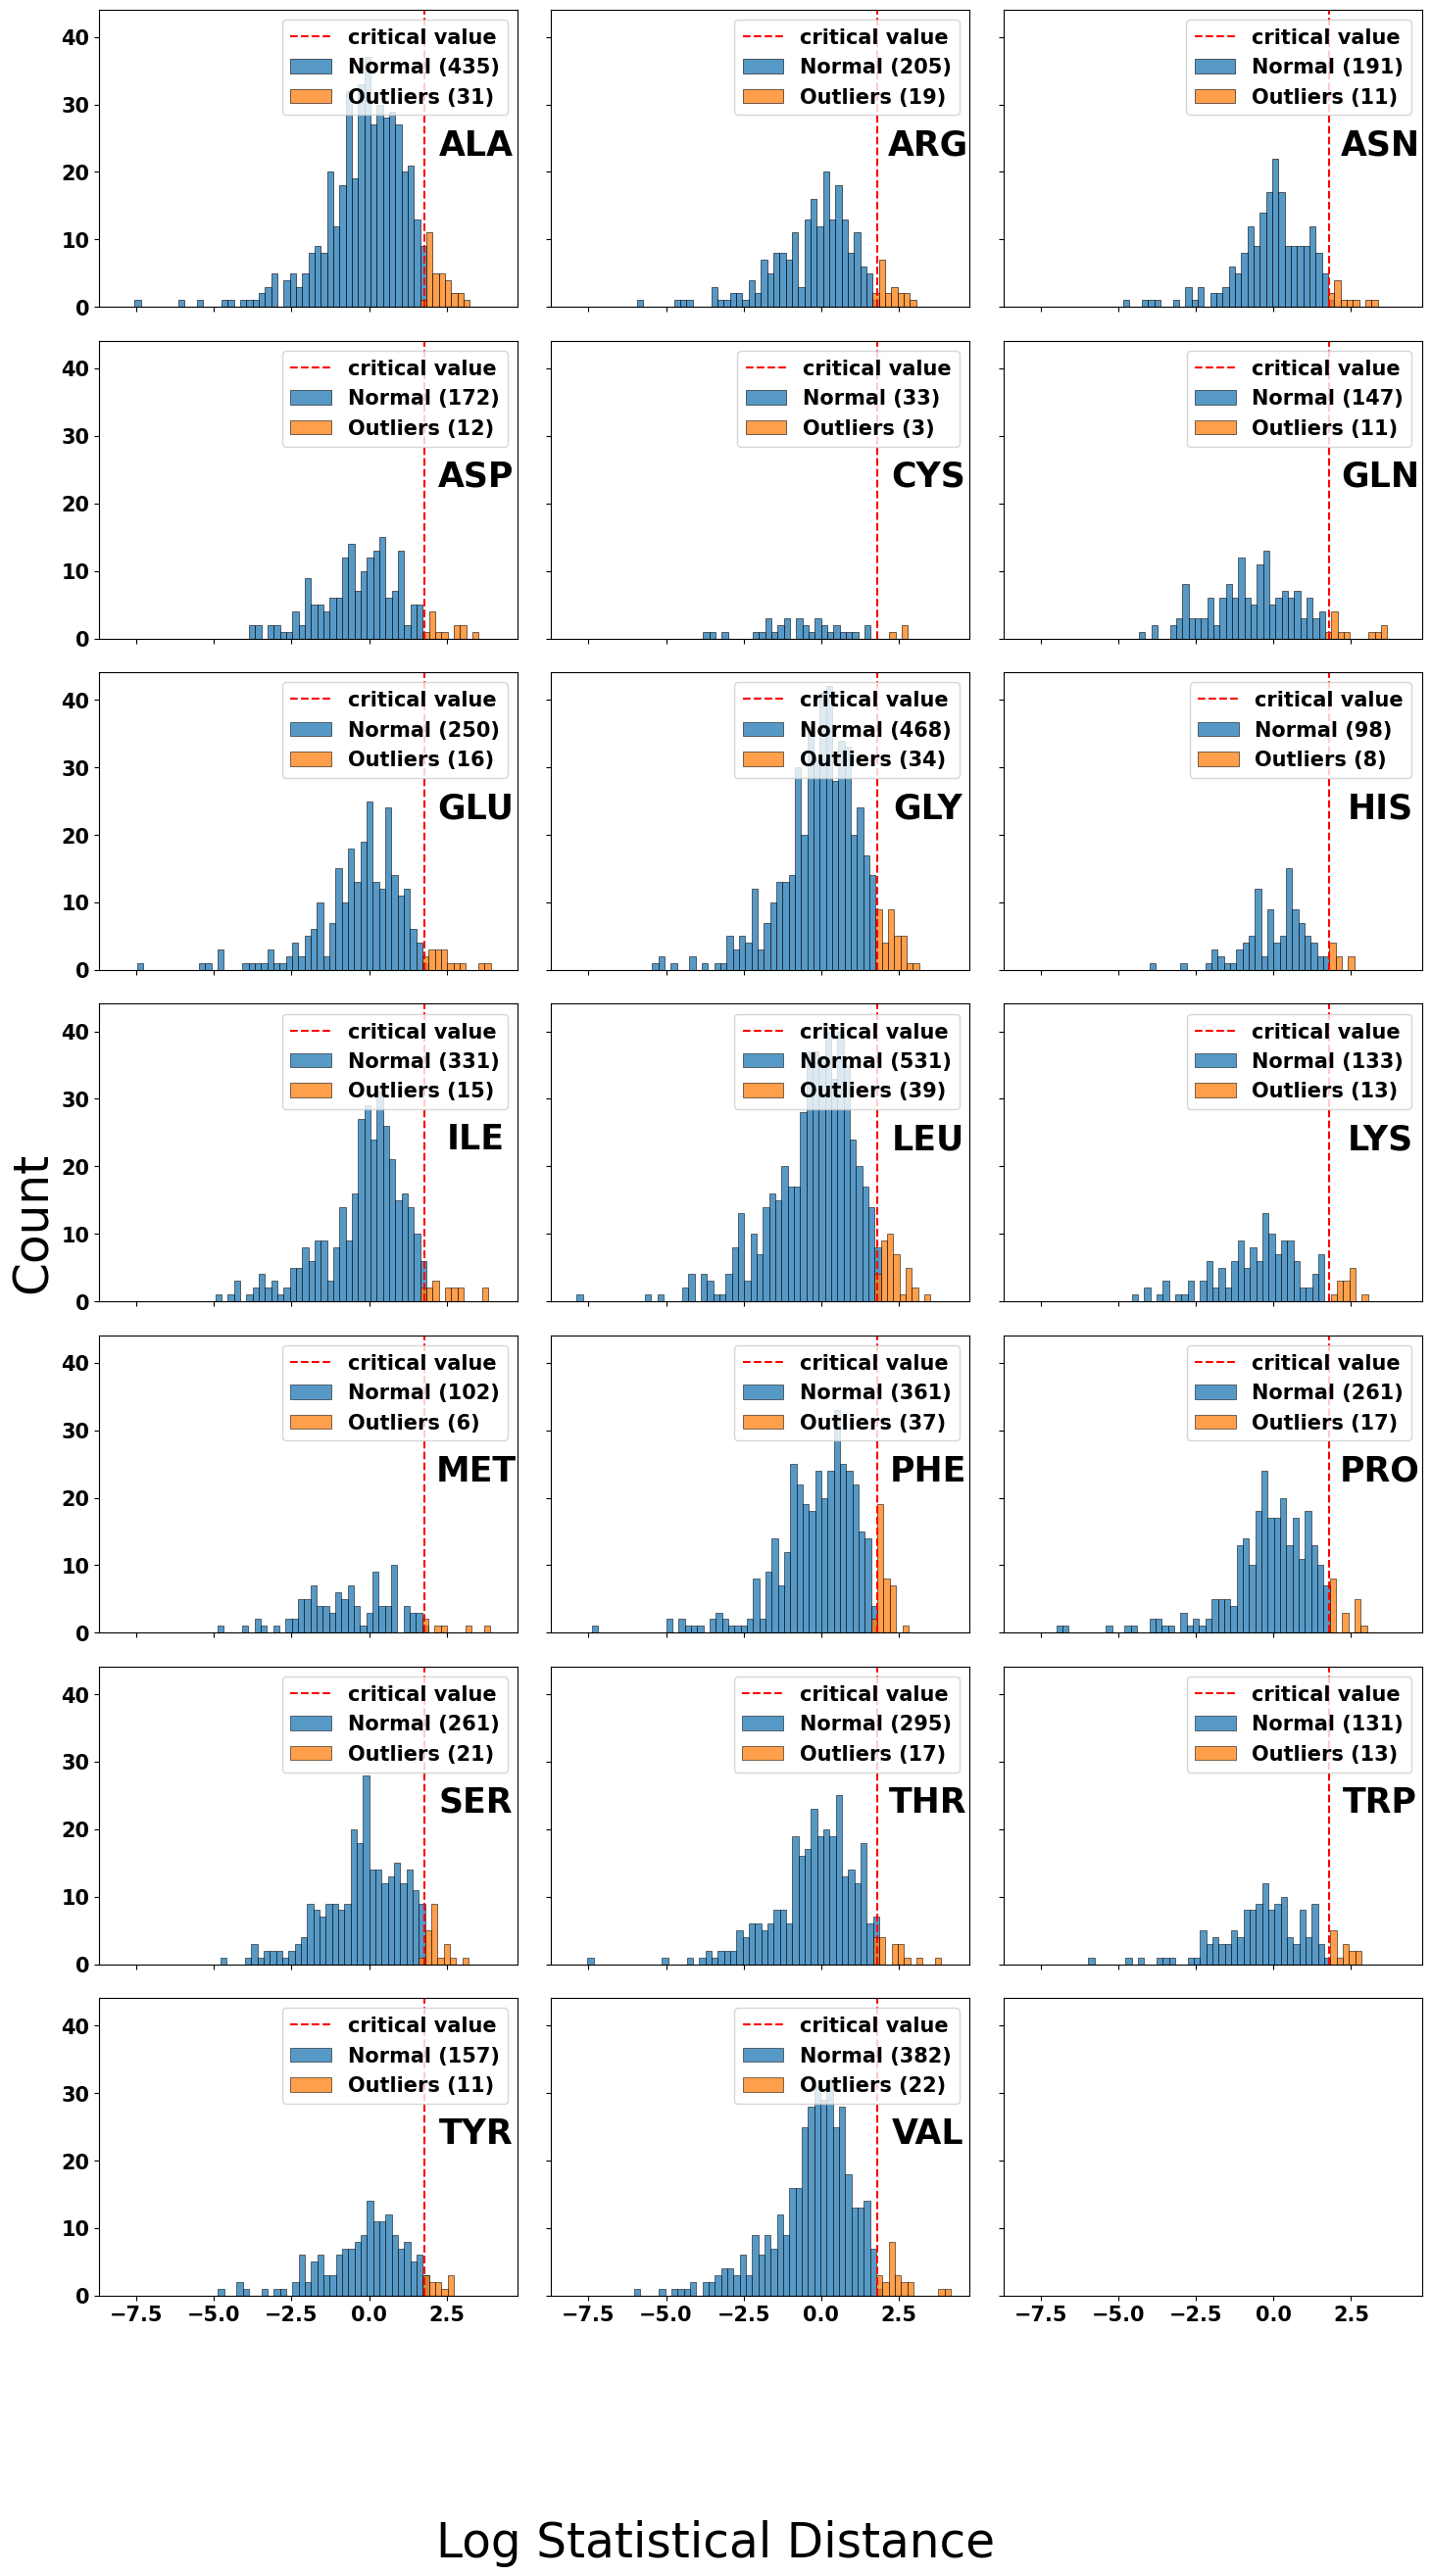

In [26]:
web.distances_hist(
    # f"./figures/distances_hist_{PROTEIN}_{EM_MAP}"
)

<Figure size 640x480 with 0 Axes>

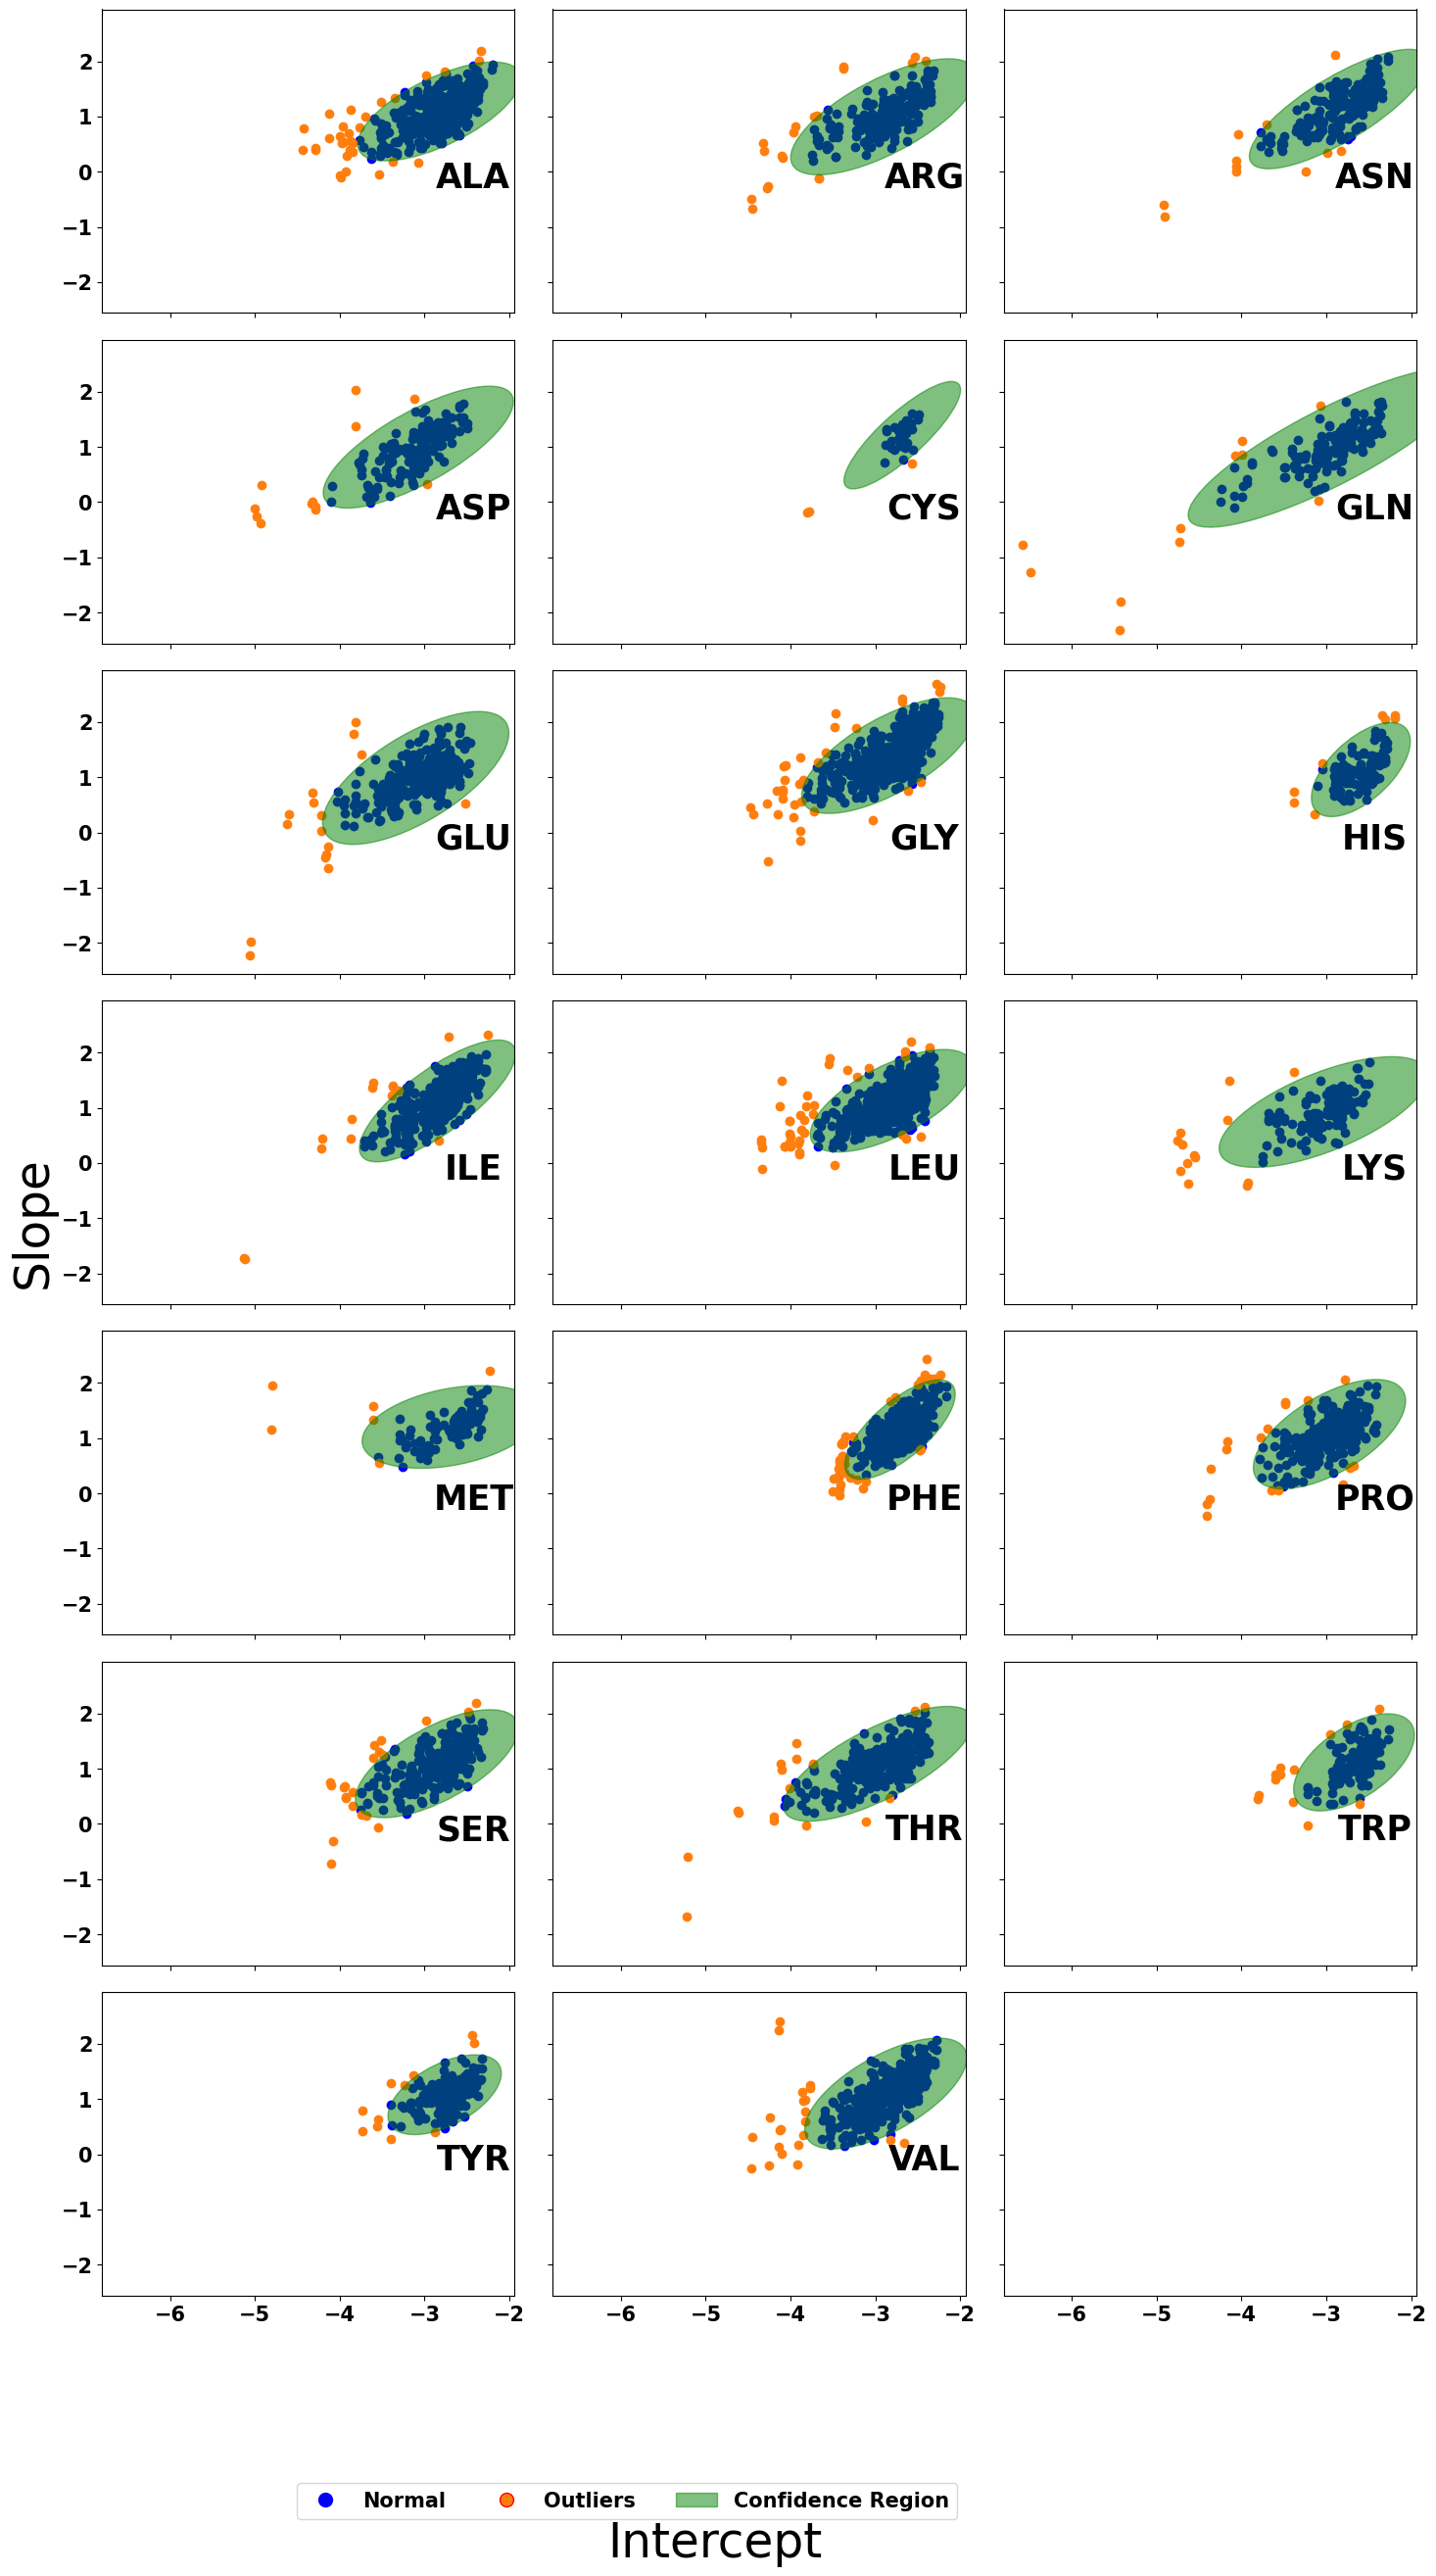

In [27]:
web.confidence_regions_plot(
    # f"./figures/confidence_regions_plot_{PROTEIN}_{EM_MAP}"
    )

<Figure size 640x480 with 0 Axes>

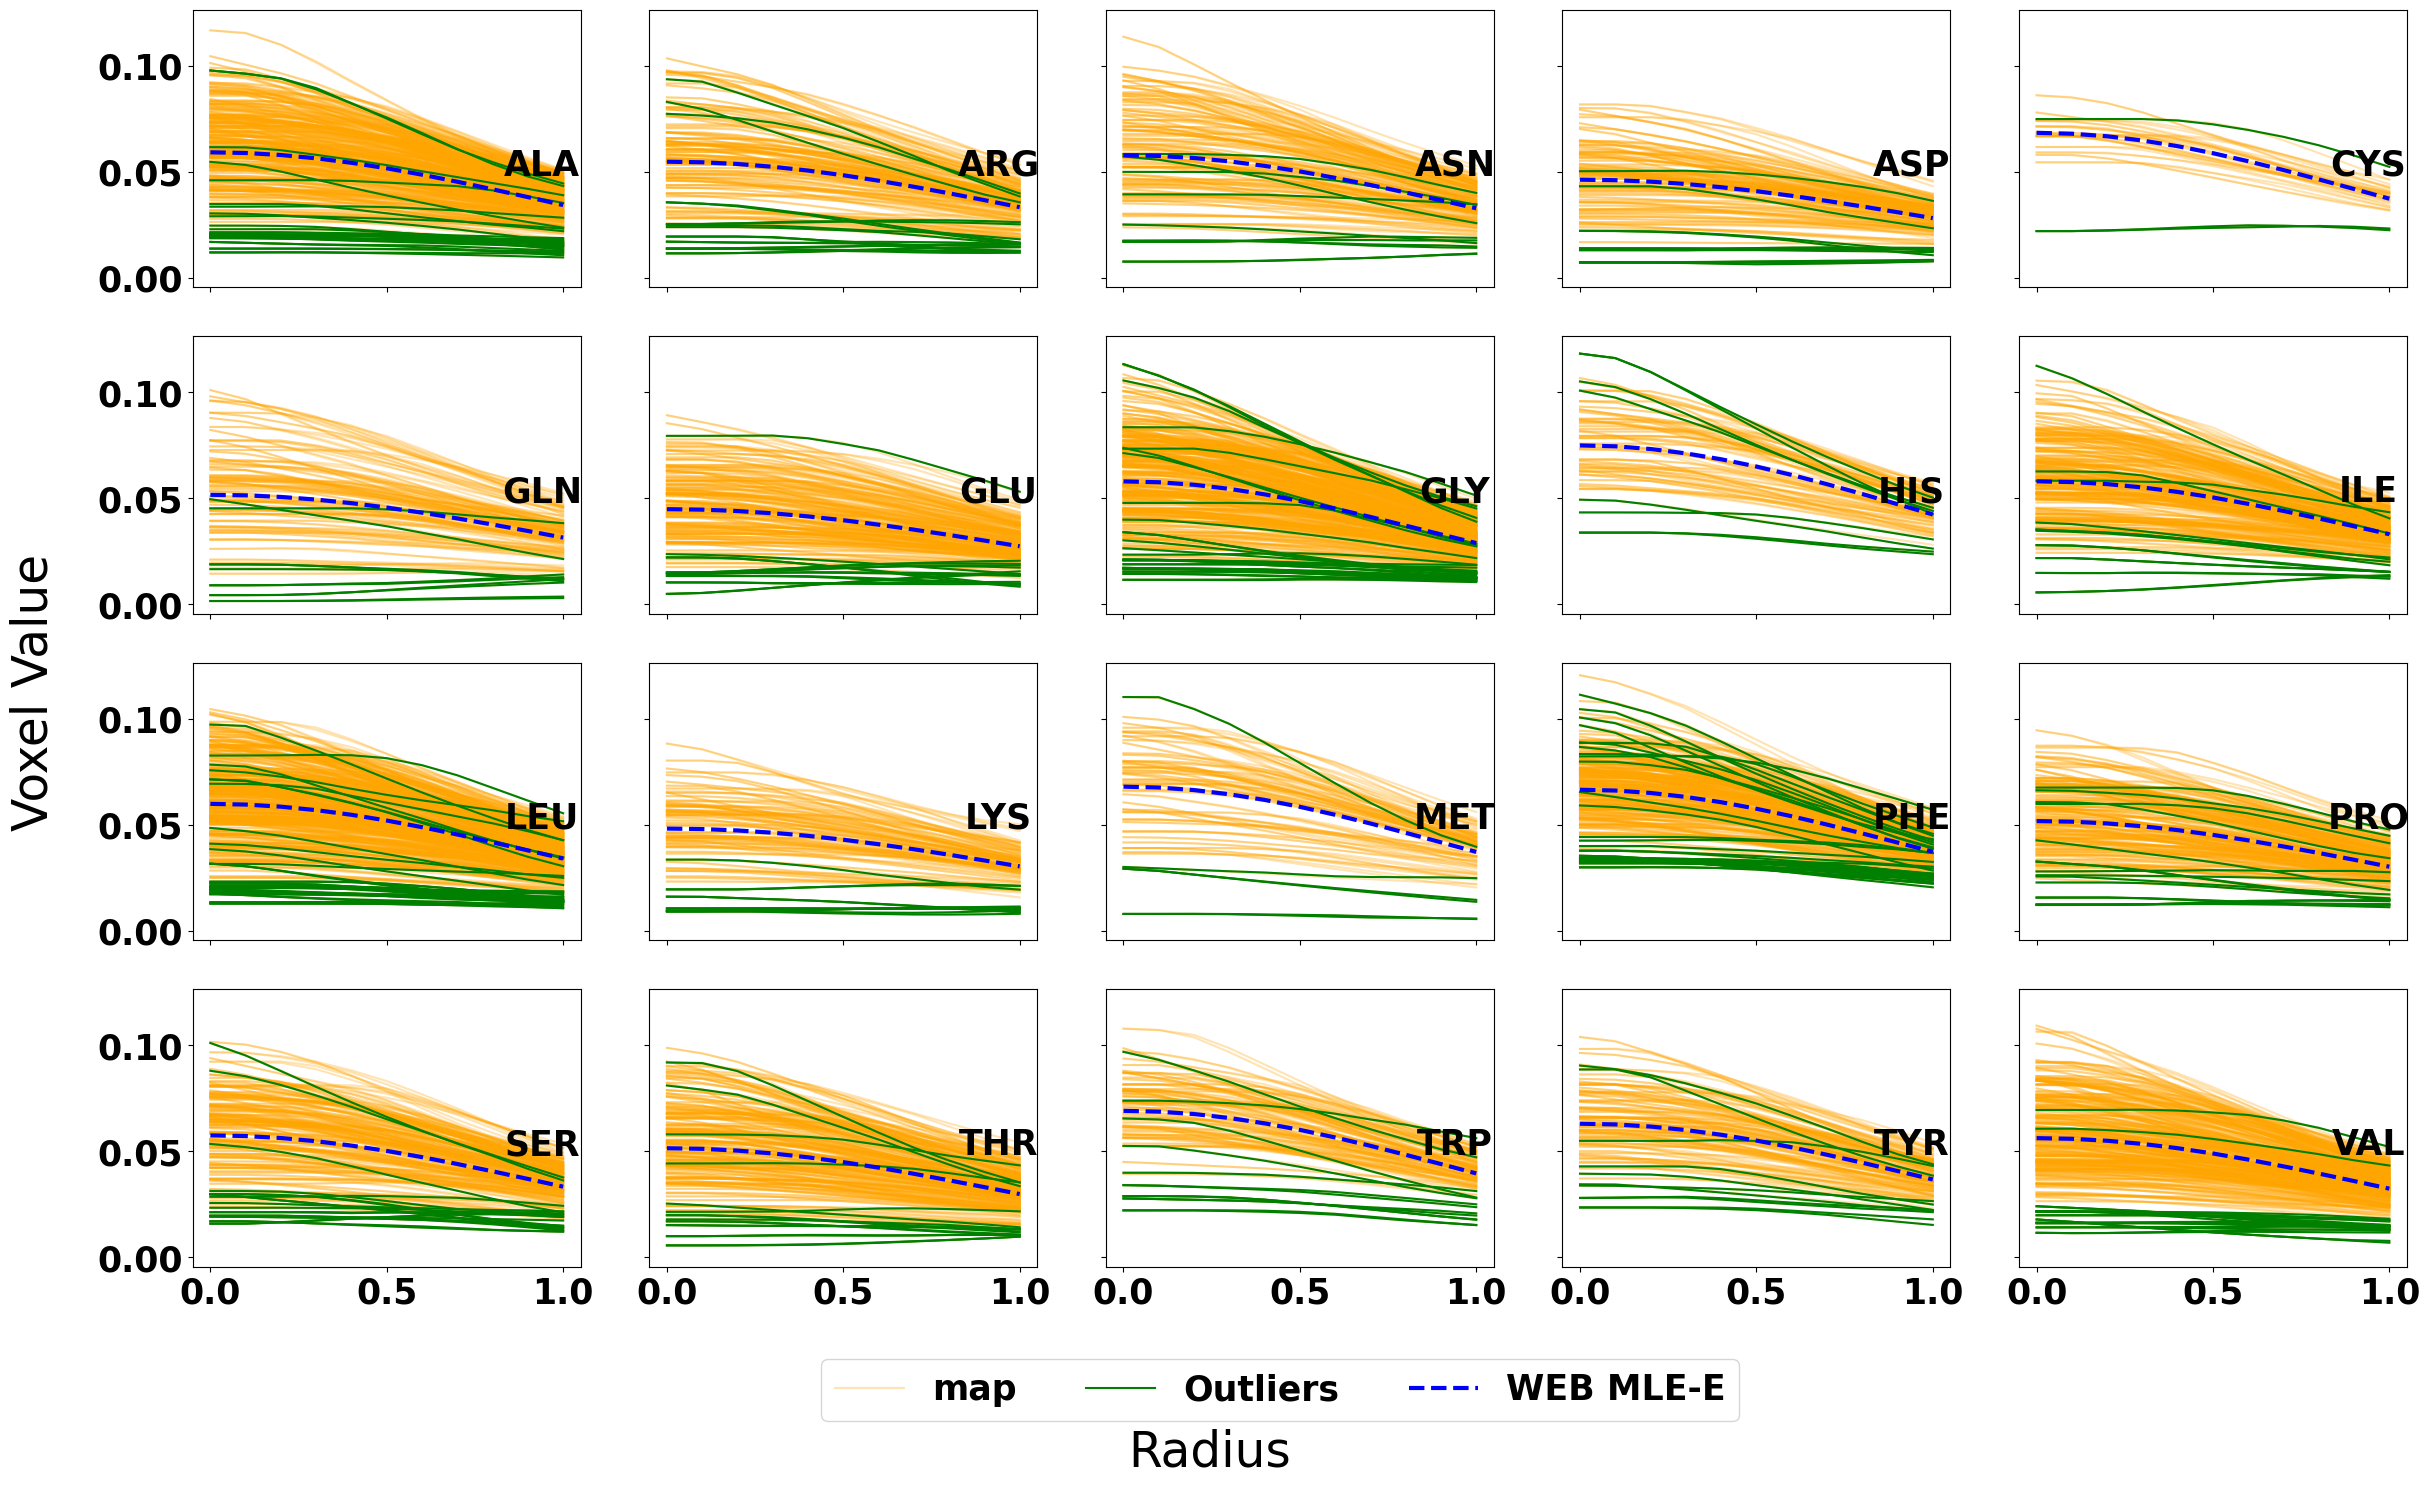

In [28]:
web.outliers_density_plot(
    # f"./figures/outliers_density_plot_{PROTEIN}_{EM_MAP}"
    )

### Plot WEB estimators for C-alpha, C, N, O

In [29]:
# PROTEIN = "6z6u"
# EM_MAP = "11103"
PROTEIN = "7d1t"
EM_MAP = "30547"

BASE_NUM_POINTS = 100
MAX_POINTS = 100
MAX_ITER = 500
ALPHA = 0.2
GAMMA = 0.5
TOL = 1e-20

root_map=f'./dataset/emd_{EM_MAP}.map'
root_pdb=f'./dataset/{PROTEIN}.pdb'

Fitted separated

In [30]:
atoms = ["CA", "C", "N", "O"]
webs = {atom: None for atom in atoms}
for atom in webs:
    web = WEB(start_radius=0, max_radius=1, gap=0.2)
    data = web.read_data(
        root_map=root_map, 
        root_pdb=root_pdb,
        atoms=[atom],
        base_num_points=BASE_NUM_POINTS, 
        max_points=MAX_POINTS
        )
    _ = web.parameters_initial()
    _ = web.WEB_iter(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)
    webs[atom] = web

 38%|███▊      | 2016/5300 [00:01<00:02, 1306.86it/s]

100%|██████████| 5300/5300 [00:03<00:00, 1598.83it/s]
INFO:root:ALA MDPDE finished in iteration: 71
INFO:root:ALA WEB finished in iteration: 28
INFO:root:===================================
INFO:root:ARG MDPDE finished in iteration: 73
INFO:root:ARG WEB finished in iteration: 43
INFO:root:===================================
INFO:root:ASN MDPDE finished in iteration: 58
INFO:root:ASN WEB finished in iteration: 20
INFO:root:===================================
INFO:root:ASP MDPDE finished in iteration: 64
INFO:root:ASP WEB finished in iteration: 26
INFO:root:===================================
INFO:root:CYS MDPDE finished in iteration: 12
INFO:root:CYS WEB finished in iteration: 43
INFO:root:===================================
INFO:root:GLN MDPDE finished in iteration: 64
INFO:root:GLN WEB finished in iteration: 35
INFO:root:===================================
INFO:root:GLU MDPDE finished in iteration: 75
INFO:root:GLU WEB finished in iteration: 23
INFO:root:==============================

In [31]:
estimators_atom = {}
for atom in webs:
    estimators_list = list(map(solve, webs[atom].mus_mle.values()))
    estimators = {name: estimator for name, estimator in zip(webs[atom].mus_mle, estimators_list)}
    estimators_atom[atom] = estimators

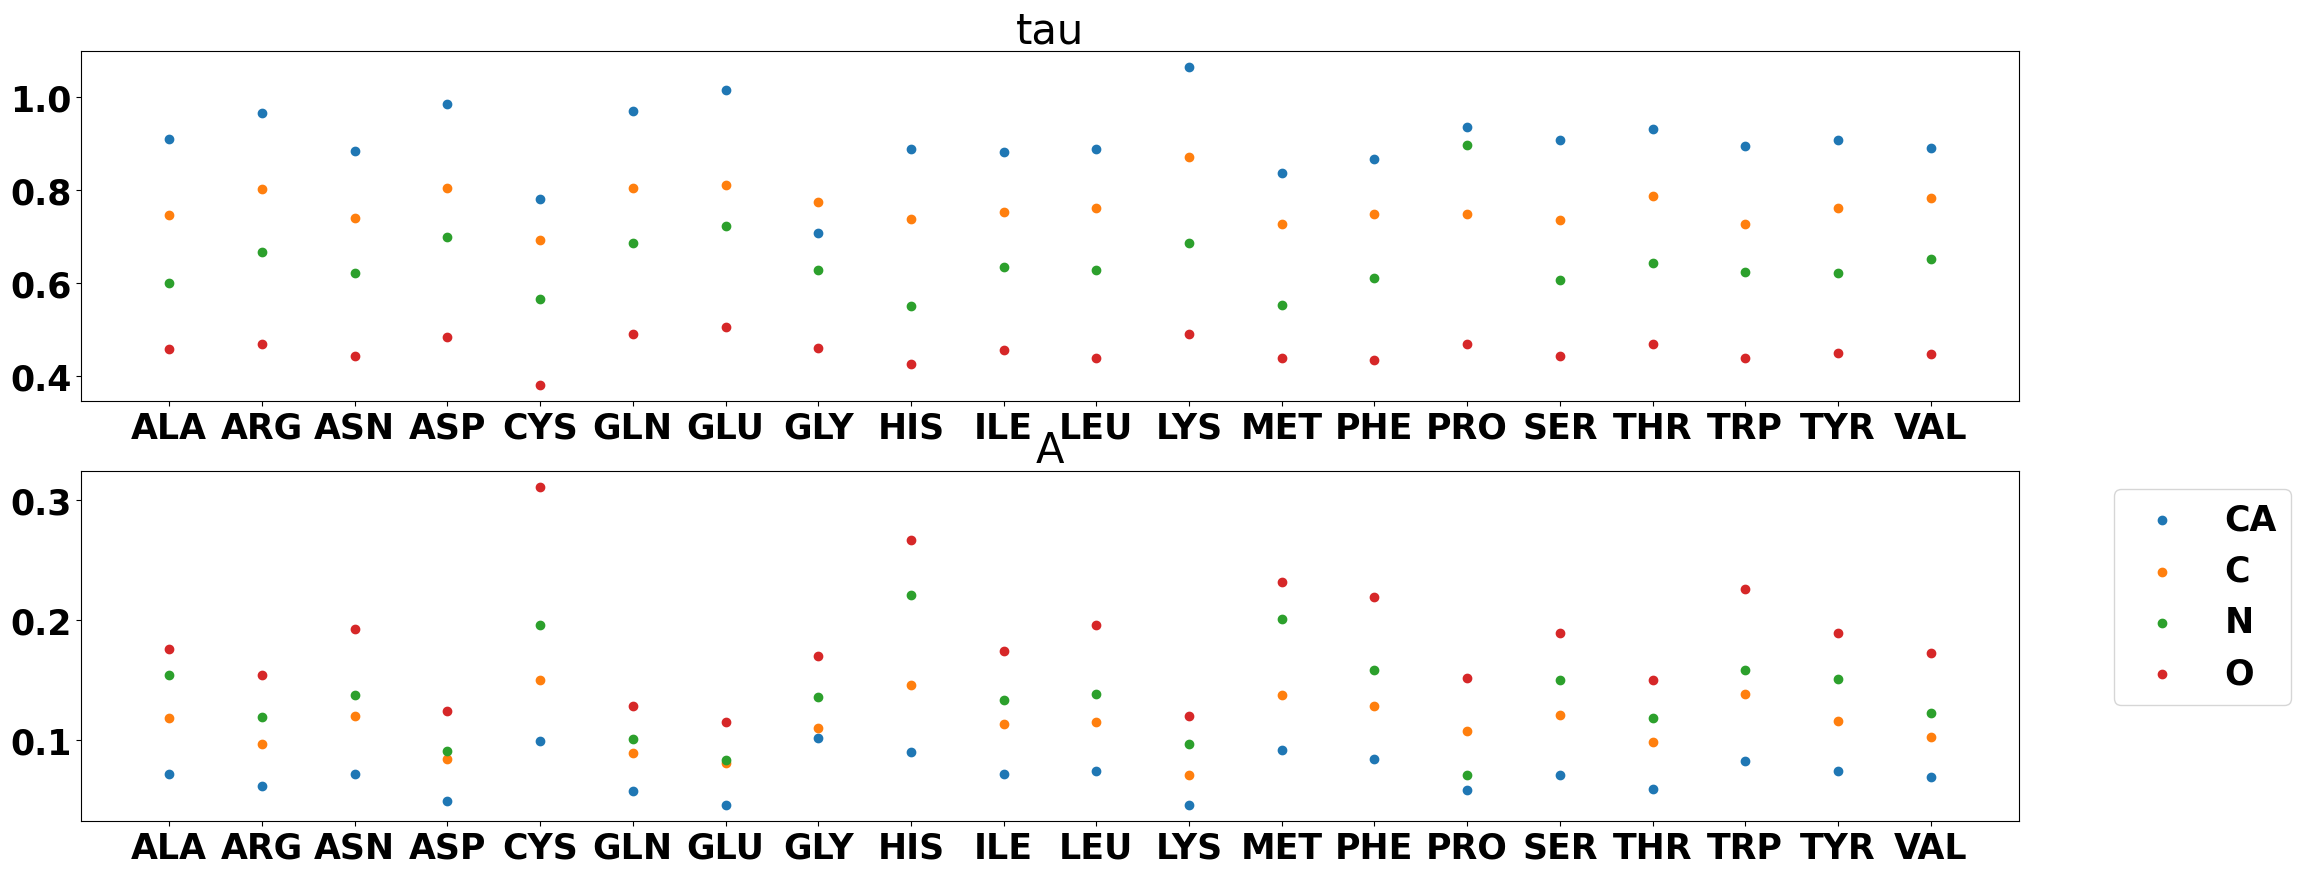

In [32]:
fig, ax = plt.subplots(2, 1, figsize=(25, 10))
for atom in estimators_atom:
    X_axis = estimators_atom[atom].keys()
    Y_axis = np.array(list(estimators_atom[atom].values()))
    ax[0].scatter(X_axis, Y_axis[:, 0], label=atom)
    ax[1].scatter(X_axis, Y_axis[:, 1], label=atom)
    ax[0].set_title("tau")
    ax[1].set_title("A")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [33]:
web_CCON = WEB(start_radius=0, max_radius=1, gap=0.2)
data = web_CCON.read_data(
    root_map=f'./dataset/emd_{EM_MAP}.map', 
    root_pdb=f'./dataset/{PROTEIN}.pdb',
    atoms=atoms,
    base_num_points=BASE_NUM_POINTS, 
    max_points=MAX_POINTS
    )
_ = web_CCON.parameters_initial()
_ = web_CCON.WEB_iter(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)

100%|██████████| 21200/21200 [00:11<00:00, 1802.73it/s]


INFO:root:ALA MDPDE finished in iteration: 72
INFO:root:ALA WEB finished in iteration: 30
INFO:root:===================================
INFO:root:ARG MDPDE finished in iteration: 73
INFO:root:ARG WEB finished in iteration: 36
INFO:root:===================================
INFO:root:ASN MDPDE finished in iteration: 63
INFO:root:ASN WEB finished in iteration: 33
INFO:root:===================================
INFO:root:ASP MDPDE finished in iteration: 64
INFO:root:ASP WEB finished in iteration: 28
INFO:root:===================================
INFO:root:CYS MDPDE finished in iteration: 68
INFO:root:CYS WEB finished in iteration: 41
INFO:root:===================================
INFO:root:GLN MDPDE finished in iteration: 64
INFO:root:GLN WEB finished in iteration: 25
INFO:root:===================================
INFO:root:GLU MDPDE finished in iteration: 75
INFO:root:GLU WEB finished in iteration: 24
INFO:root:===================================
INFO:root:GLY MDPDE finished in iteration: 92
IN

In [34]:
estimators_list_CCON = list(map(solve, web_CCON.mus_mle.values()))
estimators_CCON = {name: estimator for name, estimator in zip(web_CCON.mus_mle, estimators_list_CCON)}

In [35]:
web_all = WEB(start_radius=0, max_radius=1, gap=0.2)
data = web_all.read_data(
    root_map=f'./dataset/emd_{EM_MAP}.map', 
    root_pdb=f'./dataset/{PROTEIN}.pdb',
    atoms=None,
    base_num_points=BASE_NUM_POINTS, 
    max_points=MAX_POINTS
    )
_ = web_all.parameters_initial()
_ = web_all.WEB_iter(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)

 79%|███████▉  | 32831/41574 [00:16<00:04, 1989.99it/s]

100%|██████████| 41574/41574 [00:21<00:00, 1954.42it/s]
INFO:root:ALA MDPDE finished in iteration: 72
INFO:root:ALA WEB finished in iteration: 29
INFO:root:===================================
INFO:root:ARG MDPDE finished in iteration: 73
INFO:root:ARG WEB finished in iteration: 26
INFO:root:===================================
INFO:root:ASN MDPDE finished in iteration: 67
INFO:root:ASN WEB finished in iteration: 28
INFO:root:===================================
INFO:root:ASP MDPDE finished in iteration: 75
INFO:root:ASP WEB finished in iteration: 25
INFO:root:===================================
INFO:root:CYS MDPDE finished in iteration: 68
INFO:root:CYS WEB finished in iteration: 38
INFO:root:===================================
INFO:root:GLN MDPDE finished in iteration: 72
INFO:root:GLN WEB finished in iteration: 24
INFO:root:===================================
INFO:root:GLU MDPDE finished in iteration: 75
INFO:root:GLU WEB finished in iteration: 25
INFO:root:============================

In [36]:
estimators_list_all = list(map(solve, web_all.mus_mle.values()))
estimators_all = {name: estimator for name, estimator in zip(web_all.mus_mle, estimators_list_all)}

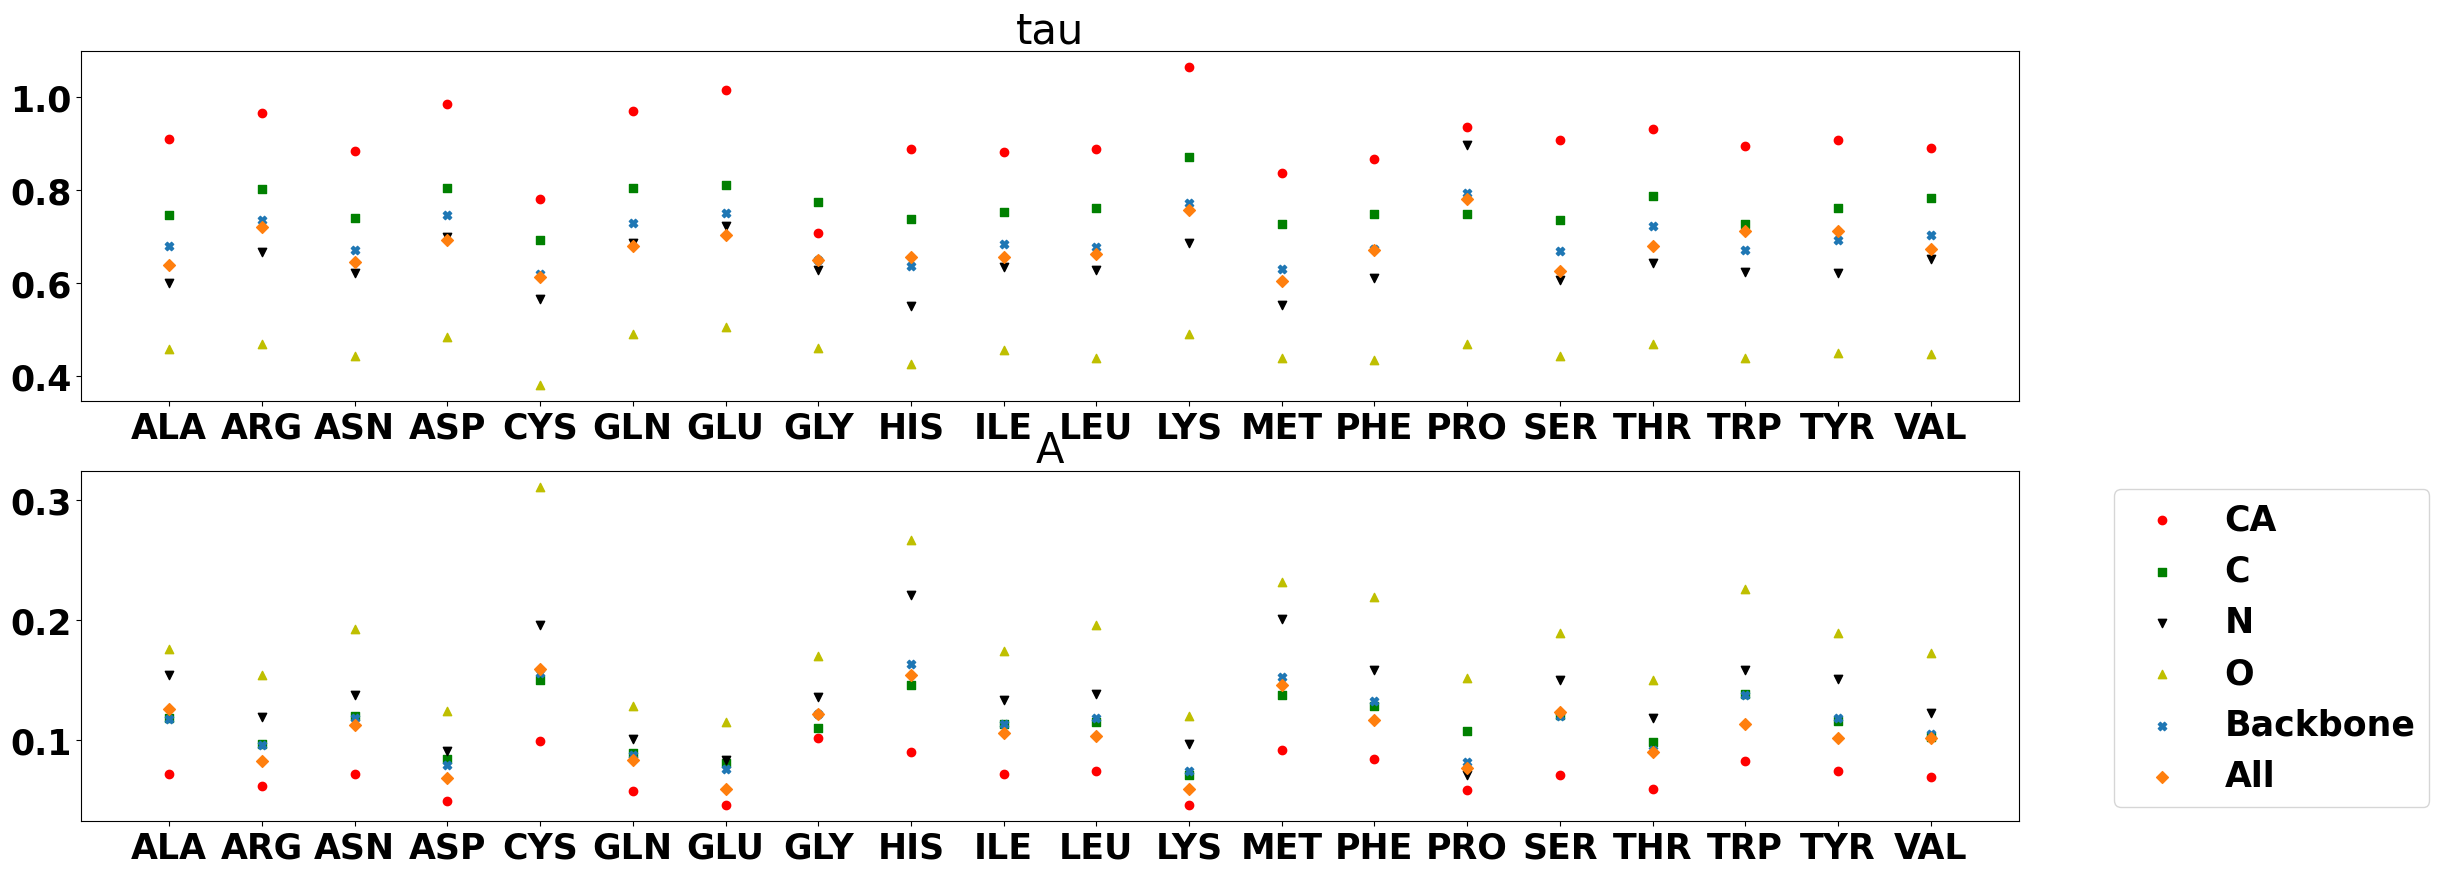

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(25, 10))
colors = ["r", "g", "black", "y"]
shapes = ["o", "s", "v", "^"]
for atom, shape, color in zip(estimators_atom, shapes, colors):
    X_axis = estimators_atom[atom].keys()
    Y_axis = np.array(list(estimators_atom[atom].values()))
    ax[0].scatter(X_axis, Y_axis[:, 0], label=atom, marker=shape, c=color)
    ax[1].scatter(X_axis, Y_axis[:, 1], label=atom, marker=shape, c=color)
    ax[0].set_title("tau")
    ax[1].set_title("A")
Y_axis_CCON = np.array(list(estimators_CCON.values()))
ax[0].scatter(X_axis, Y_axis_CCON[:, 0], label="Backbone", marker="X")
ax[1].scatter(X_axis, Y_axis_CCON[:, 1], label="Backbone", marker="X")
Y_axis_all = np.array(list(estimators_all.values()))
ax[0].scatter(X_axis, Y_axis_all[:, 0], label="All", marker="D")
ax[1].scatter(X_axis, Y_axis_all[:, 1], label="All", marker="D")
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

### F-scores

In [38]:
import scipy
def F_test(SSE_all, SSE_alone, df1, df2):
    SSE_delta = SSE_all - SSE_alone
    return (SSE_delta / df1) / (SSE_alone / df2)

Test whether we should fit separately based on amino acids

In [39]:
amino_acids = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]

F_scores_all_separate = {amino_acid: None for amino_acid in amino_acids}
p_values_all_separate = {amino_acid: None for amino_acid in amino_acids}

F_scores_all_CCON = {amino_acid: None for amino_acid in amino_acids}
p_values_all_CCON = {amino_acid: None for amino_acid in amino_acids}


# amino_acids = ["HIS"]
for amino_acid in amino_acids:
    SSE_separate = 0
    SSE_CCON = 0
    SSE_all = 0
    data_densities_len = 0
    for atom in webs:
        X_tilde = webs[atom].Xs_tilde[amino_acid][0]
        estimated_densities_separate = np.exp(X_tilde @ webs[atom].mus_mle[amino_acid])
        estimated_densities_CCON = np.exp(X_tilde @ web_CCON.mus_mle[amino_acid])
        estimated_densities_all = np.exp(X_tilde @ web_all.mus_mle[amino_acid])
        
        data_densities = webs[atom].data[amino_acid]
        
        SSE_separate += np.sum((estimated_densities_separate - data_densities) ** 2)
        SSE_CCON += np.sum((estimated_densities_CCON - data_densities) ** 2)
        SSE_all += np.sum((estimated_densities_all - data_densities) ** 2)
        data_densities_len += data_densities.shape[0] * data_densities.shape[1]

        # df11 = 2
        # df12 = data_densities_len - 
        
        df21 = 6
        df22 = data_densities_len - 8

        # F_scores_all_separate[amino_acid] = F_test(SSE_all, SSE_separate, df11, df12)
        # p_values_all_separate[amino_acid] = scipy.stats.f.sf(F_scores[amino_acid], df11, df12)

        F_scores_all_CCON[amino_acid] = F_test(SSE_CCON, SSE_separate, df21, df22)
        p_values_all_CCON[amino_acid] = scipy.stats.f.sf(F_scores_all_CCON[amino_acid], df21, df22)

In [40]:
p_values_all_CCON

{'ALA': 0.0,
 'ARG': 0.0,
 'ASN': 0.0,
 'ASP': 0.0,
 'CYS': 0.0,
 'GLN': 0.0,
 'GLU': 0.0,
 'GLY': 0.0,
 'HIS': 0.0,
 'ILE': 0.0,
 'LEU': 0.0,
 'LYS': 0.0,
 'MET': 0.0,
 'PHE': 0.0,
 'PRO': 0.0,
 'SER': 0.0,
 'THR': 0.0,
 'TRP': 0.0,
 'TYR': 0.0,
 'VAL': 0.0}

In [41]:
F_scores_all_CCON

{'ALA': 16513.227474918684,
 'ARG': 7170.901203653272,
 'ASN': 7156.306930054082,
 'ASP': 6830.931639034843,
 'CYS': 1965.0542997276586,
 'GLN': 4134.617663469056,
 'GLU': 11475.10788143969,
 'GLY': 20754.17044571252,
 'HIS': 6460.035229486849,
 'ILE': 12601.04265369801,
 'LEU': 19582.6479860504,
 'LYS': 5341.399750107019,
 'MET': 3922.9927118750775,
 'PHE': 18554.320074573432,
 'PRO': 12141.593758827474,
 'SER': 8967.27678479721,
 'THR': 8502.272458287529,
 'TRP': 6161.7341180133335,
 'TYR': 7960.708351883252,
 'VAL': 14647.48782845763}

Test whether we should fit separately based on atom

In [42]:
atoms = ["CA", "C", "N", "O"]
amino_acids = ["ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"]
webs_atom_all = {atom: None for atom in atoms}
webs_atom_three = {atom: None for atom in atoms}
webs_atom_separate = {atom: None for atom in atoms}
for atom in webs_atom_all:
    web_atom_all = WEB(start_radius=0, max_radius=1, gap=0.2)
    data = web_atom_all.read_data(
        root_map=root_map, 
        root_pdb=root_pdb,
        atoms=[atom],
        base_num_points=BASE_NUM_POINTS, 
        max_points=MAX_POINTS, 
        mode = "all"
        )
    _ = web_atom_all.parameters_initial()
    _ = web_atom_all.WEB_iter(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)
    webs_atom_all[atom] = web_atom_all

    web_atom_three = WEB(start_radius=0, max_radius=1, gap=0.2)
    data = web_atom_three.read_data(
        root_map=root_map, 
        root_pdb=root_pdb,
        atoms=[atom],
        base_num_points=BASE_NUM_POINTS, 
        max_points=MAX_POINTS, 
        mode = "three"
        )
    _ = web_atom_three.parameters_initial()
    _ = web_atom_three.WEB_iter(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)
    webs_atom_three[atom] = web_atom_three

    web_atom_separate = WEB(start_radius=0, max_radius=1, gap=0.2)
    data = web_atom_separate.read_data(
        root_map=root_map, 
        root_pdb=root_pdb,
        atoms=[atom],
        base_num_points=BASE_NUM_POINTS, 
        max_points=MAX_POINTS, 
        mode = "separate"
        )
    _ = web_atom_separate.parameters_initial()
    _ = web_atom_separate.WEB_iter(max_iter=MAX_ITER, alpha=ALPHA, gamma=GAMMA, tol=TOL)
    webs_atom_separate[atom] = web_atom_separate

100%|██████████| 5300/5300 [00:02<00:00, 1986.02it/s]


INFO:root:all MDPDE finished in iteration: 87
INFO:root:all WEB finished in iteration: 25
INFO:root:===================================
100%|██████████| 5300/5300 [00:02<00:00, 1992.41it/s]
INFO:root:GLY MDPDE finished in iteration: 57
INFO:root:GLY WEB finished in iteration: 29
INFO:root:===================================
INFO:root:PRO MDPDE finished in iteration: 65
INFO:root:PRO WEB finished in iteration: 20
INFO:root:===================================
INFO:root:others MDPDE finished in iteration: 87
INFO:root:others WEB finished in iteration: 25
INFO:root:===================================
100%|██████████| 5300/5300 [00:02<00:00, 1822.57it/s]
INFO:root:ALA MDPDE finished in iteration: 71
INFO:root:ALA WEB finished in iteration: 28
INFO:root:===================================
INFO:root:ARG MDPDE finished in iteration: 73
INFO:root:ARG WEB finished in iteration: 43
INFO:root:===================================
INFO:root:ASN MDPDE finished in iteration: 58
INFO:root:ASN WEB finish

In [43]:
F_scores_all_separate = {atom: None for atom in atoms}
p_values_all_separate = {atom: None for atom in atoms}

F_scores_all_three = {atom: None for atom in atoms}
p_values_all_three = {atom: None for atom in atoms}

length = 0
for atom in atoms:
    SSE_separate = 0
    SSE_three = 0
    SSE_all = 0
    data_densities_len = 0
    for amino_acid in amino_acids:
        X_tilde = webs_atom_separate[atom].Xs_tilde[amino_acid][0]
        estimated_densities_separate = np.exp(X_tilde @ webs_atom_separate[atom].mus_mle[amino_acid])
        
        amino_acid_three = "others" if amino_acid not in ["GLY", "PRO"] else amino_acid 
        estimated_densities_three = np.exp(X_tilde @ webs_atom_three[atom].mus_mle[amino_acid_three])
       
        estimated_densities_all = np.exp(X_tilde @ webs_atom_all[atom].mus_mle["all"])
        
        data_densities = webs_atom_separate[atom].data[amino_acid]
        
        SSE_separate += np.sum((estimated_densities_separate - data_densities) ** 2)
        SSE_three += np.sum((estimated_densities_three - data_densities) ** 2)
        SSE_all += np.sum((estimated_densities_all - data_densities) ** 2)
        data_densities_len += data_densities.shape[0] * data_densities.shape[1]

    print(atom, ":", SSE_all - SSE_separate, SSE_all - SSE_three)

    df11 = 40 - 2
    df12 = data_densities_len - 40

    df21 = 6 - 2
    df22 = data_densities_len - 6
        
    F_scores_all_separate[atom] = F_test(SSE_three, SSE_separate, df11, df12)
    p_values_all_separate[atom]= scipy.stats.f.sf(F_scores_all_separate[atom], df11, df12)
    F_scores_all_three[atom] = F_test(SSE_all, SSE_three, df21, df22)
    p_values_all_three[atom] = scipy.stats.f.sf(F_scores_all_three[atom], df21, df22)

CA : 81.78401080904064 3.494669116807245
C : 109.05369296812682 1.0292915180148157
N : 97.66309064054394 4.718503366234927
O : 73.08023508247857 1.687717008862819


In [44]:
F_scores_all_separate

{'CA': 6933.201819040917,
 'C': 5774.255258844444,
 'N': 5343.666784014037,
 'O': 4049.526468803445}

In [45]:
F_scores_all_three

{'CA': 2715.1695895802577,
 'C': 488.9477788711782,
 'N': 2422.5065527516426,
 'O': 867.4731883389462}

In [46]:
p_values_all_separate

{'CA': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0}

In [47]:
p_values_all_three

{'CA': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0}